# Intro

**Project Name:** Unsupervised multivariate anomaly detection for Hydroponic Farming 

**Project goals:** Analysis of data from a network of distributed sensors placed on racks of horizontal hydroponic farming, including:
    *- testing the correctness of the sensors throughout the container (identifying sensors that are faulty / not collecting data correctly, need additional calibration, etc.),  
    - development of a method of automatic detection of anomalies occurring in the data for a future experiment in the desiccator (based on data from one selected measurement point).*.

**Metadata:** The dataset analyzed includes measurement data from a network of sensors: 
    *- air temperature (T),
    - air humidity (H), 
    - atmospheric pressure (p), 
    - carbon dioxide concentration in the air (co2), 
    - oxygen concentration in the air (o2), 
    - illumination level in the visible band (ALS),  
    - illumination level in the infrared band (IR).*
    
The measurement network consists of 30 points where combinations of humidity and lighting temperature sensors have been placed in both bands, 4 points where combinations of temperature, humidity, atmospheric pressure and lighting sensors have been placed in both bands, and oxygen and carbon dioxide levels in the air.

The dataset contains within it data from a 7-week time period (49 calendar days, 1176 measurements), and are downloaded hourly. They are taken from an Influx-type database hooked up directly to the crop control server.

# Libs import

In [3]:
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# statistics
import pingouin
from scipy.stats import iqr
from statsmodels.tsa.seasonal import seasonal_decompose

# modelling
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report

from sklearn.decomposition import PCA

# time-series forecasting
from prophet import Prophet

# Data import

In [4]:
# import of 7 files, each has a data from one kind of sensor
dict_of_files = {'o2': 'data/influx_mean_o2_12.11_31.12.csv',  #o2
                 'co2': 'data/influx_mean_co2_12.11_31.12.csv',  #co2
                 'H': 'data/influx_mean_humidity_12.11_31.12.csv',  #humidity
                 'P': 'data/influx_mean_pressure_12.11_31.12.csv',  #atm_pressure
                 'T': 'data/influx_mean_temperature_12.11_31.12.csv',  #temperature
                 'ALS': 'data/influx_mean_light_ALS_12.11_31.12.csv',  #ALS
                 'IR': 'data/influx_mean_light_IR_12.11_31.12.csv'}  #IR

dict_of_dataframes = {}

for key, file in dict_of_files.items():
    name = pd.read_csv(file, skiprows=3, usecols=[5, 6, 9], dtype={'nodeID': 'string'}, index_col='_time')
    name.index = pd.to_datetime(name.index)
    name = name.sort_index()
    name['nodeID'] = name['nodeID'].str.replace('N0', key)
    dict_of_dataframes['data_' + key] = name
dict_of_dataframes['data_ALS']

_value   nodeID
_time                                          
2023-11-12 00:00:00+00:00    20.000000  ALS.017
2023-11-12 00:00:00+00:00     0.000000  ALS.052
2023-11-12 00:00:00+00:00   971.533333  ALS.051
2023-11-12 00:00:00+00:00     0.000000  ALS.050
2023-11-12 00:00:00+00:00  1870.233333  ALS.049
...                                ...      ...
2023-12-30 23:00:00+00:00  3898.600000  ALS.029
2023-12-30 23:00:00+00:00  1891.433333  ALS.027
2023-12-30 23:00:00+00:00  1916.433333  ALS.026
2023-12-30 23:00:00+00:00  2223.766667  ALS.024
2023-12-30 23:00:00+00:00  1335.966667  ALS.054

[37517 rows x 2 columns]

In [5]:
dict_of_dataframes.keys()

dict_keys(['data_o2', 'data_co2', 'data_H', 'data_P', 'data_T', 'data_ALS', 'data_IR'])

In [6]:
# creating a long-format datasets
data_o2 = dict_of_dataframes['data_o2']
data_co2 = dict_of_dataframes['data_co2']
data_H = dict_of_dataframes['data_H']
data_P = dict_of_dataframes['data_P']
data_T = dict_of_dataframes['data_T']
data_ALS = dict_of_dataframes['data_ALS']
data_IR = dict_of_dataframes['data_IR']

In [7]:
# creating a wide-format datasets
data_o2_wide = data_o2.pivot(columns='nodeID', values='_value')
data_co2_wide = data_co2.pivot(columns='nodeID', values='_value')
data_H_wide = data_H.pivot(columns='nodeID', values='_value')
data_P_wide = data_P.pivot(columns='nodeID', values='_value')
data_T_wide = data_T.pivot(columns='nodeID', values='_value')
data_ALS_wide = data_ALS.pivot(columns='nodeID', values='_value')
data_IR_wide = data_IR.pivot(columns='nodeID', values='_value')

# EDA - the whole network
At the outset, each type of sensor (the entire measurement network) was examined separately to detect sensors that were defective, collecting data incorrectly, and requiring recalibration.

## o2 - oxygen level

Sensors measuring the level of oxygen (percentage concentration of o2 in the air) in the container were placed at 4 measurement points in the network, these are points 17/18/19/20.

In [8]:
# basic stats of all data
stats_o2 = data_o2.describe()
stats_o2

_value
count  4704.000000
mean     17.680523
std       5.784111
min       0.040000
25%      19.457938
50%      19.681333
75%      19.904458
max      20.475583

In [9]:
# basic stats of each sensor
stats_o2_wide = data_o2_wide.describe()
stats_o2_wide

nodeID       o2.017       o2.018       o2.019       o2.020
count   1176.000000  1176.000000  1176.000000  1176.000000
mean      19.805879    20.139180    19.573317    11.203718
std        0.072413     0.187137     0.062336     8.816092
min       19.419750    19.724583    19.351333     0.040000
25%       19.758167    19.964667    19.533479     0.195021
50%       19.810792    20.129333    19.576125    18.210375
75%       19.850437    20.319437    19.610604    19.283396
max       19.998833    20.475583    19.800750    19.708017

In [10]:
# checking for NA values
pd.isna(data_o2_wide).sum()

nodeID
o2.017    0
o2.018    0
o2.019    0
o2.020    0
dtype: int64

C:\Users\vasya\AppData\Local\Temp\ipykernel_21556\422580380.py:4: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.lineplot(data=data_o2,


Text(0.5, 1.0, 'Lineplot of o2 sensors data in time')

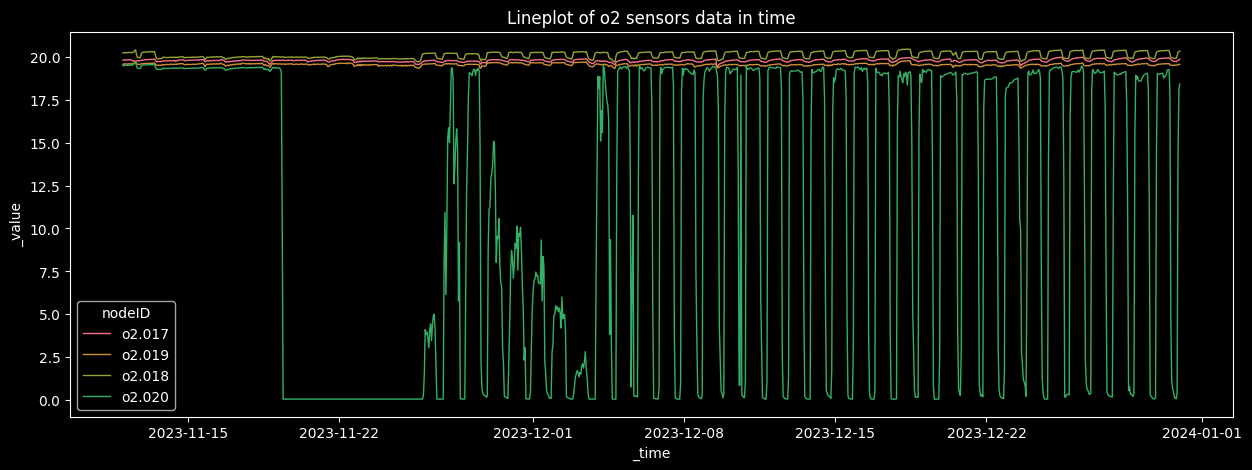

In [11]:
# plotting the timelines of each sensor
palette_v = sns.color_palette("husl", 8)
plt.figure(figsize=(15, 5))
sns.lineplot(data=data_o2,
             x=data_o2.index,
             y='_value',
             hue='nodeID',
             linewidth=1,
             palette=palette_v)
plt.title('Lineplot of o2 sensors data in time')

C:\Users\vasya\AppData\Local\Temp\ipykernel_21556\3009273558.py:3: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.boxplot(data=data_o2_wide, palette=palette_v, ax = ax1)


Text(0.5, 1.0, 'Density plots of all o2 sensors')

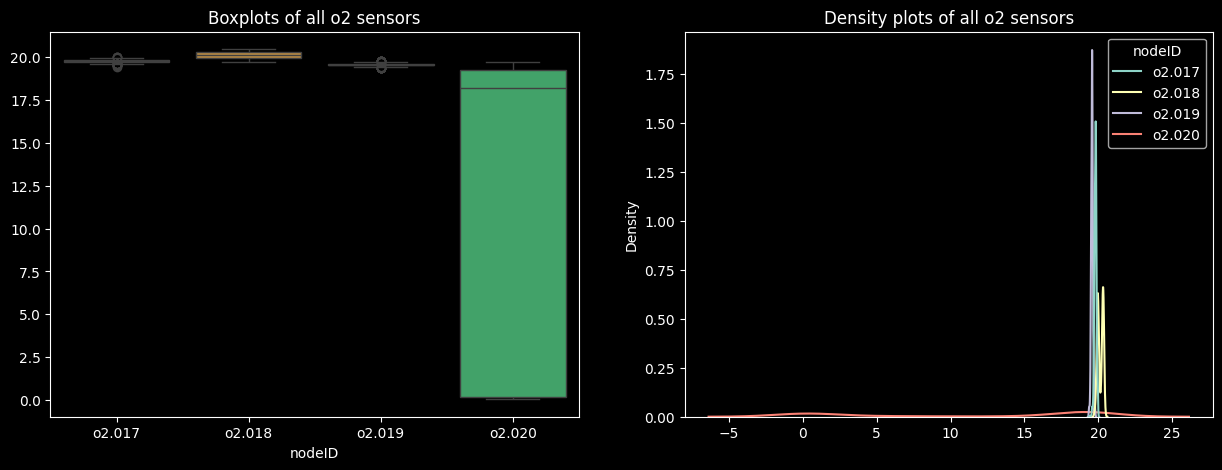

In [12]:
# plotting the statistics of each sensor
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=data_o2_wide, palette=palette_v, ax = ax1)
ax1.set_title('Boxplots of all o2 sensors')
sns.kdeplot(data=data_o2_wide, ax = ax2)
ax2.set_title('Density plots of all o2 sensors')

**Conclusions:** the data from the oxygen level sensors (% of oxygen in the air) are complete, no missing values were recorded. On the other hand, based on the above graphs, we can infer the presence of a large number of outliers in the data from the o2.020 sensor - most likely, the sensor was damaged or covered by a plant - too many incorrect data. ** Sensor o2.020 - incorrect operation throughout the period.

In [13]:
data_o2_new = data_o2[data_o2['nodeID'] != 'o2.020'] # dropping the o2.020 sensor and checking of the other sensors once again

In [14]:
data_o2_new.describe() 

_value
count  3528.000000
mean     19.839458
std       0.262019
min      19.351333
25%      19.609104
50%      19.808500
75%      19.969521
max      20.475583

C:\Users\vasya\AppData\Local\Temp\ipykernel_21556\468269972.py:3: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.lineplot(data=data_o2_new,


Text(0.5, 1.0, 'Lineplot of o2 data in time (without point 20')

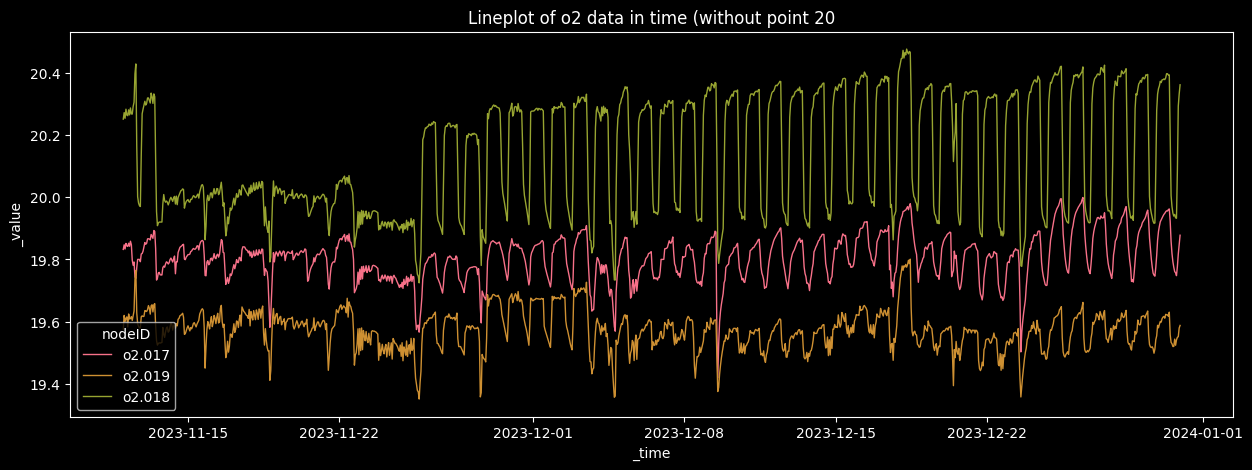

In [15]:
palette_v = sns.color_palette("husl", 8)
plt.figure(figsize=(15, 5))
sns.lineplot(data=data_o2_new,
             x=data_o2_new.index,
             y='_value',
             hue='nodeID',
             linewidth=1,
             palette=palette_v)
plt.title('Lineplot of o2 data in time (without point 20')

C:\Users\vasya\AppData\Local\Temp\ipykernel_21556\134846280.py:4: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(data=data_o2_wide_new, palette=palette_v, ax = ax1)


Text(0.5, 1.0, 'Density plots of all o2 sensors (without point 20)')

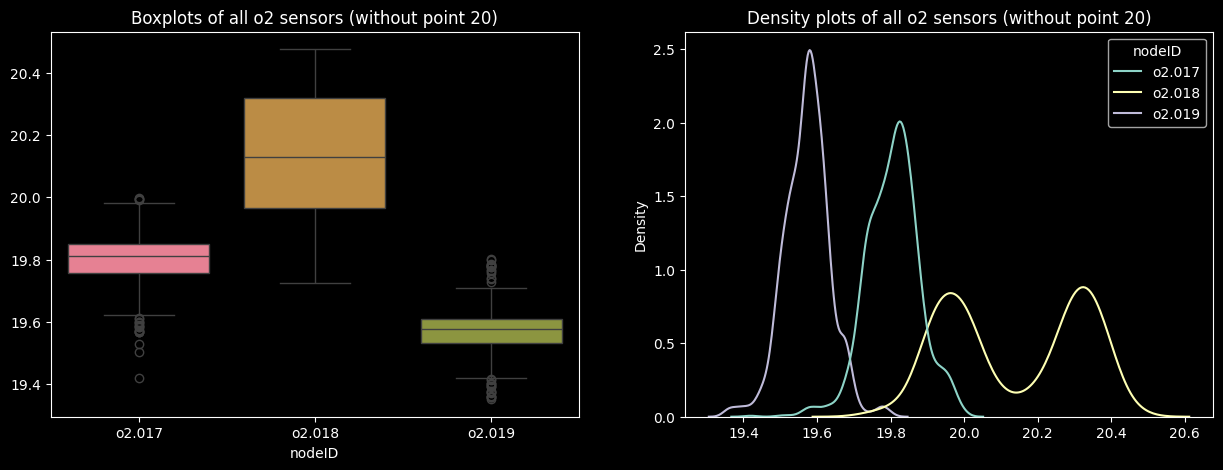

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

data_o2_wide_new = data_o2_wide[['o2.017', 'o2.018', 'o2.019']]
sns.boxplot(data=data_o2_wide_new, palette=palette_v, ax = ax1)
ax1.set_title('Boxplots of all o2 sensors (without point 20)')

sns.kdeplot(data=data_o2_wide.drop(columns=['o2.020'], axis=1), ax = ax2)
ax2.set_title('Density plots of all o2 sensors (without point 20)')

**Conclusions:** from the above graphs can be deduced, 
1. that the sensors at points 17 and 19 are working correctly, they have quite similar distributions, the discrepancy in the position of the distribution may be due to the different location of the sensors, since the level of o2 in the container is directly dependent on the number of plants in the section oras the stage of their vegetation.
2. Each of these sensors (17 and 19) has a number of outliers, which has a lot of potential for qualifying one of these points for later modeling (anomaly/outlier detection). 
3. data from sensor 18 does not show extreme values, although the distribution does not look correct - hence a preventive validation of this sensor is recommended.
4. o2 sensor at point 20 to be checked by a technician.

## co2 - carbon dioxide level

Sensors measuring the level of oxygen (ppm co2 in the air) in the container were placed at 4 measurement points in the network, these points are 17/18/19/20 - identical to o2.

In [17]:
data_co2.describe()

_value
count  4704.000000
mean    668.757839
std     277.708348
min     398.491667
25%     503.479167
50%     611.195833
75%     736.472917
max    2589.941667

In [18]:
data_co2_wide.describe()

nodeID      co2.017      co2.018      co2.019      co2.020
count   1176.000000  1176.000000  1176.000000  1176.000000
mean     663.804839   646.999358   683.279616   680.947541
std      269.760854   265.894765   283.759787   289.544277
min      398.491667   403.125000   402.258333   402.975000
25%      494.291667   508.718750   504.060417   505.058333
50%      611.170833   588.237500   629.754167   622.491667
75%      734.731250   685.702083   762.437500   760.645833
max     2456.550000  2535.425000  2589.941667  2566.183333

In [19]:
data_co2_wide.isna().sum()  # no NA's

nodeID
co2.017    0
co2.018    0
co2.019    0
co2.020    0
dtype: int64

C:\Users\vasya\AppData\Local\Temp\ipykernel_21556\1833191936.py:2: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.lineplot(data=data_co2, x=data_co2.index, y='_value', hue='nodeID', linewidth=1,


Text(0.5, 1.0, 'Timeline of co2 sensors')

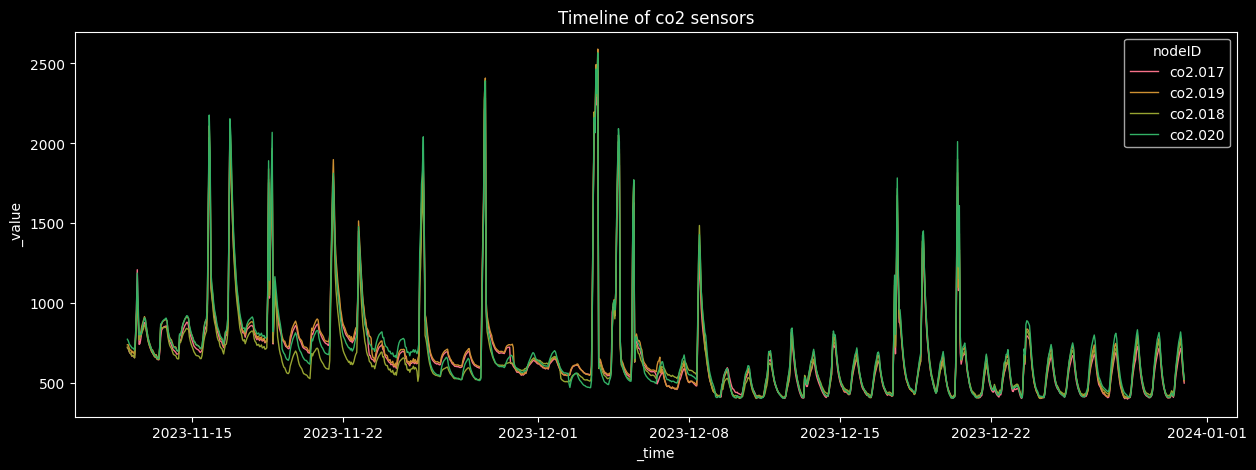

In [20]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=data_co2, x=data_co2.index, y='_value', hue='nodeID', linewidth=1,
             palette=palette_v)
plt.title('Timeline of co2 sensors')

Text(0.5, 1.0, 'Density plot of co2 sensors')

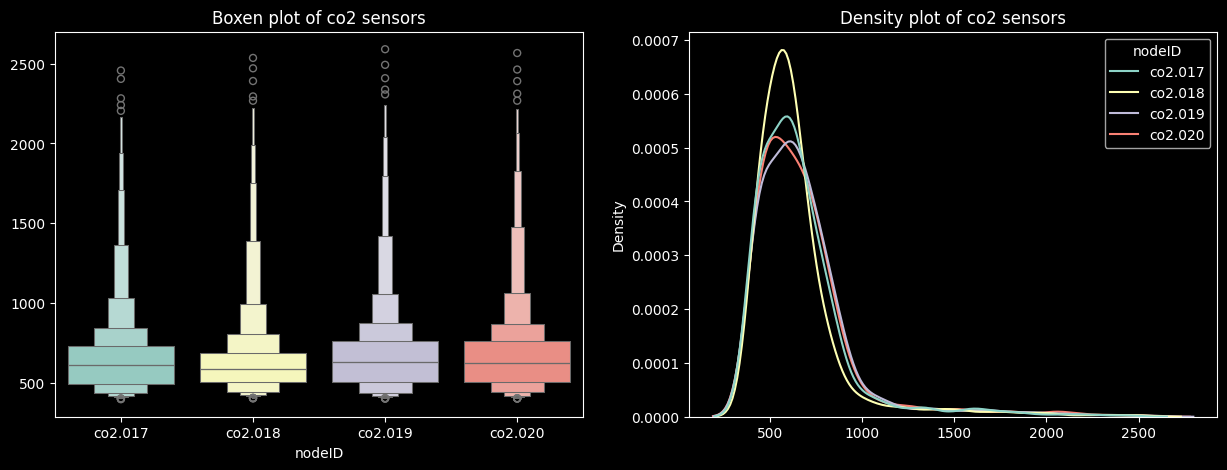

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
sns.boxenplot(data=data_co2_wide, ax = ax1)
ax1.set_title('Boxen plot of co2 sensors')

sns.kdeplot(data=data_co2_wide, ax = ax2)
ax2.set_title('Density plot of co2 sensors')

In [22]:
pingouin.kruskal(data=data_co2, dv='_value', between='nodeID')

Source  ddof1       H     p-unc
Kruskal  nodeID      3  23.873  0.000027

In [23]:
pingouin.kruskal(data=data_co2[data_co2['nodeID'] != 'co2.018'], dv='_value', between='nodeID') # Ho - population means are equal, pval > 0.05 - fail to reject Ho

Source  ddof1        H     p-unc
Kruskal  nodeID      2  5.49607  0.064054

From the results of the Kruskal-Wallis test, it can be concluded that there is no statistically significant difference between the values from the sensors co2.017, co2.019, co2.020. Which confirms the correct operation of the sensors, and the homogeneous level of co2 in the air throughout the container. In contrast, the average values on the co2.018 sensor differ slightly from the other three, which may be related to the specifics of the planting in a particular area of the container.

Text(0.5, 1.0, 'Lineplot of last 2 days of co2 sensors')

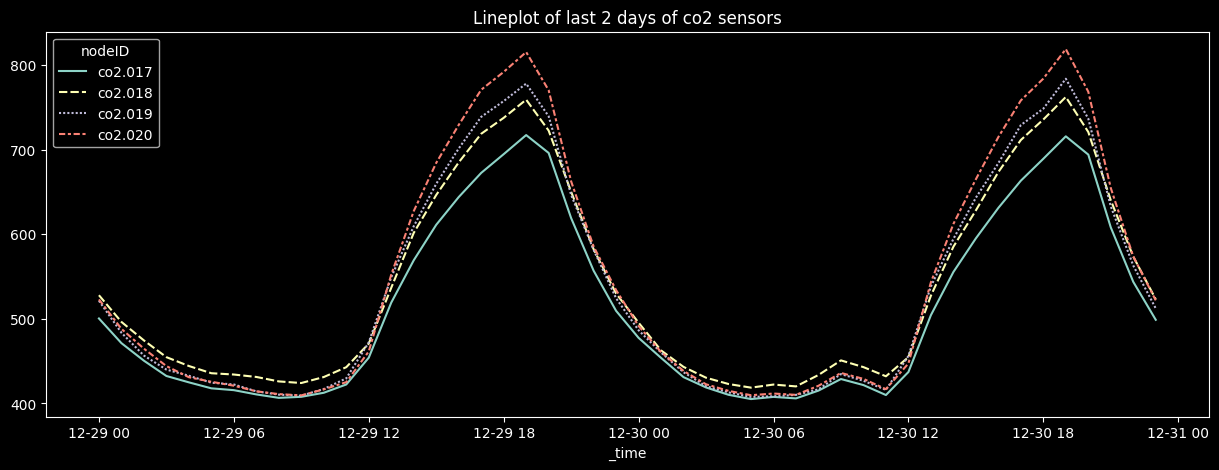

In [24]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=data_co2_wide.tail(48))
plt.title('Lineplot of last 2 days of co2 sensors')#2 ostatnie doby

**Conclusions:** From the EDA of the data from the sensors of carbon dioxide concentration in the air of the container can be deduced:

1. all 4 sensors continuously recorded data - no missing values
2. daily fluctuations of data are recorded in an overt manner, which is related to the daily cycle of plant vegetation
3. co2.017, co2.019, co2.020 sensors gain data with similar values, which confirms the correctness of the sensors, data from the sensor co2.018 slightly deviate from the others, but this may be due to the location.  
4. in addition, there are visible anomalies captured by the naked eye (suddenly increasing levels of co2) recorded on all four sensors - these peaks indicate the entry of workers into the container, which indicates the correct operation of all sensors.

## P - atmospheric pressure

Sensors measuring atmospheric pressure (hPa) in the container were placed at 4 measurement points in the network, these are points 17/18/19/20 - identical to o2 and co2.

In [25]:
data_P.describe()

_value
count  4704.000000
mean    992.065078
std      15.009797
min     947.955833
25%     982.425208
50%     992.408333
75%    1001.985208
max    1030.209167

In [26]:
data_P_wide.describe()

nodeID        P.017        P.018        P.019        P.020
count   1176.000000  1176.000000  1176.000000  1176.000000
mean     995.569817   985.593998   997.073332   990.023164
std       13.535533    15.524778    12.992369    15.007970
min      952.123333   948.106667   947.955833   949.721667
25%      986.027083   973.686917   987.910000   980.284792
50%      994.543333   985.392917   995.982500   990.372083
75%     1004.993750   996.766458  1005.689375  1000.011250
max     1029.090000  1027.937500  1030.209167  1028.850833

In [27]:
data_P_wide.isna().sum()

nodeID
P.017    0
P.018    0
P.019    0
P.020    0
dtype: int64

C:\Users\vasya\AppData\Local\Temp\ipykernel_21556\3419032472.py:2: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.lineplot(data=data_P, x=data_P.index, y='_value', hue='nodeID', linewidth=1,


Text(0.5, 1.0, 'Timeline of pressure sensors')

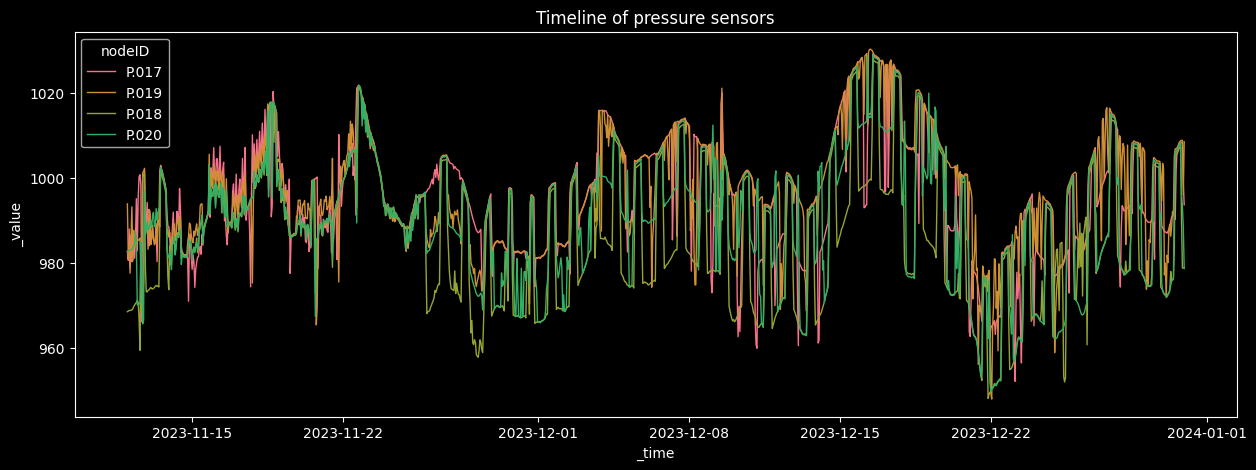

In [28]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=data_P, x=data_P.index, y='_value', hue='nodeID', linewidth=1,
             palette=palette_v)
plt.title('Timeline of pressure sensors')

Text(0.5, 1.0, 'Density plot of pressure sensors')

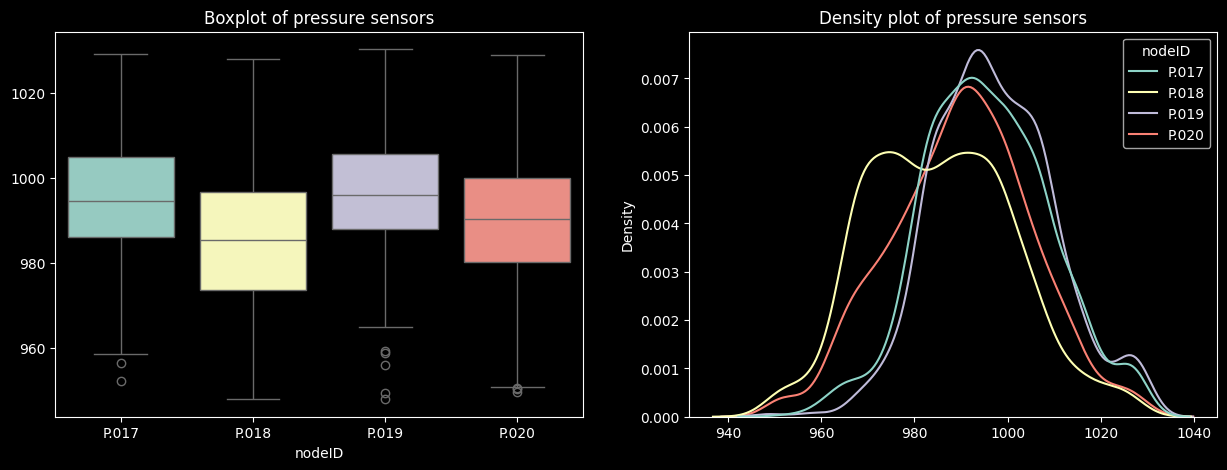

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
sns.boxplot(data_P_wide, ax = ax1)
ax1.set_title('Boxplot of pressure sensors')
sns.kdeplot(data_P_wide, ax = ax2)
ax2.set_title('Density plot of pressure sensors')

**Conclusions:**.
1. each sensor collected data over the whole measurement period, no missing values.
2. the data has a very high level of fluctuation - to consult a technician. 
3. as in the case of co2 sensors, the data from measurement points 17/19/20 have a very similar distribution, while the data from sensor 18 is shaped differently, which confirms once again that at point 18 there are slightly different conditions (probably due to the condition / amount of plants).

## T - air temperature

Sensor measuring air temperature (℃) are placed at 34 measurement points of the network insinde the container, and one outside, these are points 17-52 and X0 (outside)

In [30]:
data_T.describe()

_value
count  37838.000000
mean      17.106163
std        4.406908
min      -45.000000
25%       15.945708
50%       17.239456
75%       18.628104
max       31.400000

In [31]:
data_T_wide.describe()

nodeID        T.017        T.018        T.019        T.020        T.024  \
count   1176.000000  1176.000000  1176.000000  1176.000000  1176.000000   
mean      16.230000    19.592491    15.914719    18.791163    16.280434   
std        1.271325     3.558382     1.282655     2.915895     1.226898   
min        7.055583    11.660345    10.414500    11.118917    10.515417   
25%       15.430625    16.065562    15.112604    16.109708    15.437833   
50%       16.260375    19.432500    15.777292    18.315458    16.338458   
75%       17.003521    23.095667    16.579062    21.382771    17.006896   
max       20.074833    27.549750    19.646917    27.932583    19.392250   

nodeID        T.025        T.026        T.027        T.029        T.030  ...  \
count   1176.000000  1176.000000  1176.000000  1176.000000  1176.000000  ...   
mean      18.539957    17.302286    17.772687    11.697353    17.707377  ...   
std        2.734076     1.502907     2.024136    19.804254     1.757528  ...   
min       11.834914    10.874500    11.768966   -45.000000    12.050948  ...   
25%       16.020625    16.108250    16.206604    15.618167    16.437646  ...   
50%       18.317208    17.715750    17.752208    17.463333    17.646042  ...   
75%       20.820896    18.169833    19.449042    20.754979    19.113458  ...   
max       26.321833    20.514250    24.178833    25.095250    22.713750  ...   

nodeID        T.046        T.047        T.048        T.049         T.050  \
count   1176.000000  1176.000000  1176.000000  1176.000000  1.000000e+01   
mean      17.399975    16.119687    12.271291    16.356026  3.140000e+01   
std        1.761434     0.971600     7.500439     0.980859  6.905234e-15   
min       11.002417    10.141667     0.000000    10.361750  3.140000e+01   
25%       15.889479    15.422083     0.000000    15.638933  3.140000e+01   
50%       17.436250    16.146958    16.150375    16.415875  3.140000e+01   
75%       18.756104    16.967000    17.400271    17.195458  3.140000e+01   
max       23.860250    18.145250    19.388103    18.386500  3.140000e+01   

nodeID        T.051  T.052        T.053        T.054          X0  
count   1176.000000   10.0  1176.000000  1176.000000  321.000000  
mean      17.178823    0.0    16.997742    16.810061   17.545244  
std        1.596347    0.0     1.187645     1.112413    1.514191  
min       11.336500    0.0    10.067750    10.476167   11.769903  
25%       16.012771    0.0    16.100229    15.903875   16.461194  
50%       17.191292    0.0    17.373667    17.129000   17.685403  
75%       18.365250    0.0    17.926125    17.707583   18.581292  
max       23.364333    0.0    19.538500    19.163583   20.625667  

[8 rows x 35 columns]

In [32]:
data_T_wide.isna().sum().sort_values(ascending=False)

nodeID
T.052    1166
T.050    1166
X0        855
T.035      67
T.031      67
T.040       1
T.046       0
T.042       0
T.043       0
T.044       0
T.045       0
T.047       0
T.048       0
T.049       0
T.051       0
T.053       0
T.054       0
T.041       0
T.017       0
T.039       0
T.018       0
T.037       0
T.036       0
T.034       0
T.033       0
T.032       0
T.030       0
T.029       0
T.027       0
T.026       0
T.025       0
T.024       0
T.020       0
T.019       0
T.038       0
dtype: int64

In [33]:
# checking out each sensor's timeline separately
#sns.relplot(kind = 'line', data = data_T, x = data_T.index, y = '_value', col = 'nodeID', col_wrap = 4)

Text(0.5, 1.0, 'Boxplots of all temperature sensors')

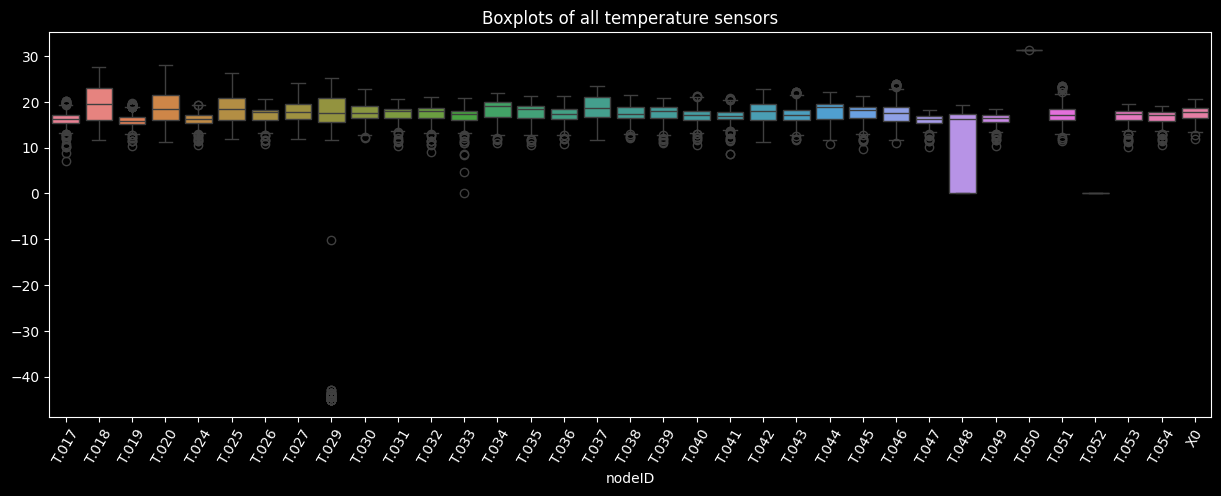

In [34]:
plt.figure(figsize=(15, 5))
sns.boxplot(data_T_wide)
plt.xticks(rotation=60)
plt.title('Boxplots of all temperature sensors')

**Conclusions"**
1. Sensors T.052, T.050, registered the only one measuremens -> the sensors aren't working properly, or they are damaged.
2. Outdoor sensor X0 registered only 28% of the all timeline, from the plot we can assume that it was added to the network a little bit later. 
3. Sensor T.048 shows no NAs, but about 25% of measuremens are zero values -> probably damaged/defected sensor.
4. Sensor T.029 shows values outside the range of the sensor, also damaged, or incorrectly calibrated.
5. sensor T.018 shows too high amplitude of read values, compared to other sensors - to consider, possible check.
6. sensor T.035 and T.031 show 5.7% missing values, sensor failure, but from the charts it appears that the failure has been fixed.
7. sensor T.040 shows <1% of missing values, sensor failure, but from the graphs it appears that it has been repaired.

## H - air humidity

Sensors measuring air humidity (%) were placed at 34 measurement points in the network inside the container are points 17-52.

The project documentation shows that the humidity sensor is integrated with the air temperature sensor -> pay special attention to the sensors that were rejected in the previous step.

In [35]:
data_H.describe()

_value
count  37517.000000
mean      78.146500
std       14.513367
min        0.000000
25%       66.995833
50%       79.785833
75%       90.363333
max      100.000000

In [36]:
data_H_wide.describe()

nodeID        H.017        H.018        H.019        H.020        H.024  \
count   1176.000000  1176.000000  1176.000000  1176.000000  1176.000000   
mean      84.585683    70.908571    84.468749    73.348825    84.310121   
std       10.391862    18.699760     9.374908    16.851557     8.834943   
min       64.015966    37.497414    55.700000    42.562931    61.356034   
25%       74.155625    51.493902    75.360208    55.222917    75.423750   
50%       86.427500    66.085417    82.708750    70.202500    82.422083   
75%       94.039792    90.288958    93.798750    90.648542    93.216042   
max      100.000000    98.290833   100.000000    98.723333    99.874167   

nodeID        H.025        H.026        H.027        H.029        H.030  ...  \
count   1176.000000  1176.000000  1176.000000  1176.000000  1176.000000  ...   
mean      74.773177    80.996891    78.435292    78.708349    78.607561  ...   
std       15.437122     9.789405    12.758543    16.118272    12.773356  ...   
min       42.668966    60.811207    54.878333    45.130172    55.863793  ...   
25%       59.891875    71.624167    65.563125    61.617083    65.275000  ...   
50%       70.383333    79.275833    76.285000    84.875833    77.256667  ...   
75%       90.770833    90.897083    91.131458    93.231667    90.766458  ...   
max       98.089167    98.417500    98.654167   100.000000    98.894167  ...   

nodeID        H.045        H.046        H.047        H.048        H.049  \
count   1176.000000  1176.000000  1176.000000  1176.000000  1176.000000   
mean      77.399350    78.839849    83.009031    60.385553    82.354885   
std       11.554136    12.995832     9.153006    37.716551     9.355215   
min       57.204310    48.643103    62.395000     0.000000    59.895000   
25%       65.276875    64.603333    73.195833     0.000000    72.320226   
50%       76.850982    81.010833    84.829167    78.637917    84.149583   
75%       89.417500    91.436458    91.258125    90.027292    90.756458   
max       97.843333    99.259167    98.451667    98.240000    98.115833   

nodeID         H.050        H.051  H.052        H.053        H.054  
count   1.000000e+01  1176.000000   10.0  1176.000000  1176.000000  
mean    7.640000e+01    79.136015    0.0    79.881874    80.937250  
std     5.400956e-14    12.416982    0.0    10.195823    10.081542  
min     7.640000e+01    53.839655    0.0    56.033333    55.641667  
25%     7.640000e+01    65.062708    0.0    68.894375    70.117500  
50%     7.640000e+01    80.510417    0.0    82.019801    82.852500  
75%     7.640000e+01    90.540833    0.0    88.338125    89.701042  
max     7.640000e+01    98.403333    0.0    97.528333    98.146667  

[8 rows x 34 columns]

In [37]:
data_H_wide.isna().sum().sort_values(ascending=False)

nodeID
H.052    1166
H.050    1166
H.031      67
H.035      67
H.040       1
H.041       0
H.042       0
H.043       0
H.044       0
H.045       0
H.017       0
H.039       0
H.047       0
H.048       0
H.049       0
H.051       0
H.053       0
H.046       0
H.038       0
H.018       0
H.037       0
H.036       0
H.034       0
H.033       0
H.032       0
H.030       0
H.029       0
H.027       0
H.026       0
H.025       0
H.024       0
H.020       0
H.019       0
H.054       0
dtype: int64

In [38]:
#sns.relplot(kind = 'line', data = data_H, x = data_H.index, y = '_value', col = 'nodeID', col_wrap = 2)

**Conclusions:** the conclusions about the non-functioning sensors are the same as for the temperature sensors, which will agree, since the sensors are integrated.
1. sensors at points 29/31/35/40/48/50/52 - failed / incorrect calibration - to be analyzed by a technician. 
2. sensor at point 18 - review of graphs by technician.

## ALS i IR - reflected light in visible (ALS) and infrared (IR) bands

These sensors measure the level of light reflected from the plants (Lx), which only indicates the size of the plant(s) that are located under the sensors (directly the vegetation state of the plants can be examined using a hyperspectral camera). The sensors are integrated into one, for this reason only ALS was analyzed, and only for missing values (tested for the subject of sensor damage).

In [39]:
data_ALS.describe()

_value
count  37517.000000
mean    1164.071001
std     1450.901797
min        0.000000
25%        0.000000
50%      434.433333
75%     1965.300000
max     5170.133333

In [40]:
data_ALS_wide.describe()

nodeID      ALS.017      ALS.018      ALS.019      ALS.020      ALS.024  \
count   1176.000000  1176.000000  1176.000000  1176.000000  1176.000000   
mean      31.071283   284.786359   338.261530   195.713483  1130.880420   
std       80.771253   267.763673   318.059849   191.238153  1098.380343   
min        0.000000     0.000000     0.000000     0.000000     0.000000   
25%        0.000000     0.000000     5.791667     3.350000    11.766667   
50%        4.000000   285.133333   276.000000   160.000000  1996.233333   
75%       20.000000   602.433333   698.350000   417.458333  2268.625000   
max     1482.033333   679.633333   944.000000   536.033333  2466.500000   

nodeID      ALS.025      ALS.026      ALS.027      ALS.029      ALS.030  ...  \
count   1176.000000  1176.000000  1176.000000  1176.000000  1176.000000  ...   
mean    2281.053856  1086.903724  1121.433622  2276.723905  1101.317461  ...   
std     2219.203110  1054.343027  1091.407128  2213.531007  1068.007138  ...   
min        0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       14.708333     0.000000     0.000000     0.000000     4.191667  ...   
50%     4095.800000  1925.650000  1638.500000  3933.083333  1978.916667  ...   
75%     4576.016667  1984.208333  2207.725000  4229.325000  2118.883333  ...   
max     4955.066667  2412.800000  2536.566667  5170.133333  2424.066667  ...   

nodeID      ALS.045      ALS.046      ALS.047      ALS.048      ALS.049  \
count   1176.000000  1176.000000  1176.000000  1176.000000  1176.000000   
mean    2451.314434  1801.246896   652.256077   206.121850   758.816634   
std     1833.017239  2100.069676   649.519935   355.185432   741.614805   
min        0.000000     0.000000     0.000000     0.000000     0.000000   
25%        0.000000     0.000000     4.866667     0.000000     6.425000   
50%     3101.466667   320.000000   583.366667     7.583333   768.816667   
75%     4249.133333  4400.083333  1332.050000   109.850000  1421.991667   
max     4470.966667  4581.747899  1915.166667   942.000000  1957.400000   

nodeID  ALS.050      ALS.051  ALS.052      ALS.053      ALS.054  
count      10.0  1176.000000     10.0  1176.000000  1176.000000  
mean        0.0   472.606390      0.0   760.356591   750.643221  
std         0.0   555.313274      0.0   600.180568   698.729615  
min         0.0     0.000000      0.0     0.000000     0.000000  
25%         0.0     0.000000      0.0     0.000000     2.266667  
50%         0.0    79.333333      0.0   947.316667   809.750000  
75%         0.0  1152.716667      0.0  1208.000000  1426.608333  
max         0.0  1196.633333      0.0  1810.366667  1965.133333  

[8 rows x 34 columns]

In [41]:
data_ALS_wide.isna().sum().sort_values(ascending=False)

nodeID
ALS.052    1166
ALS.050    1166
ALS.031      67
ALS.035      67
ALS.040       1
ALS.041       0
ALS.042       0
ALS.043       0
ALS.044       0
ALS.045       0
ALS.017       0
ALS.039       0
ALS.047       0
ALS.048       0
ALS.049       0
ALS.051       0
ALS.053       0
ALS.046       0
ALS.038       0
ALS.018       0
ALS.037       0
ALS.036       0
ALS.034       0
ALS.033       0
ALS.032       0
ALS.030       0
ALS.029       0
ALS.027       0
ALS.026       0
ALS.025       0
ALS.024       0
ALS.020       0
ALS.019       0
ALS.054       0
dtype: int64

In [42]:
#sns.relplot(kind = 'line', data = data_ALS, x = data_ALS.index, y = '_value', col = 'nodeID', col_wrap = 4)

Text(0.5, 1.0, 'Boxplots of all ALS sensors')

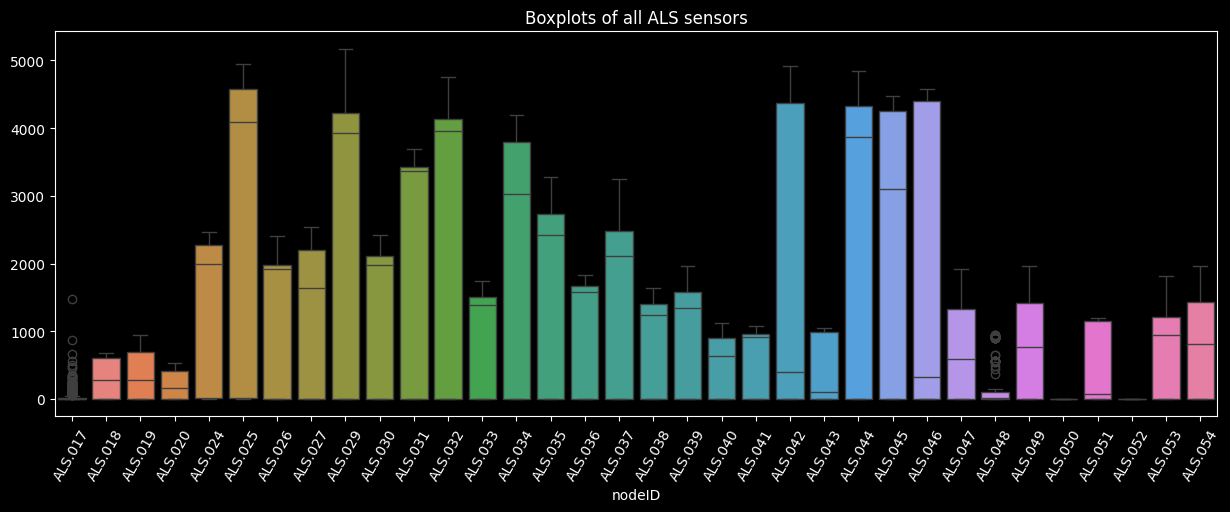

In [43]:
plt.figure(figsize=(15, 5))
sns.boxplot(data_ALS_wide)
plt.xticks(rotation=60)
plt.title('Boxplots of all ALS sensors')

**Conclusions:**. 
1. each sensor shows very different values from each other, which indicates the natural differences that occur in the vegetation stage of each plant (especially its size). 
2. sensors at points 17/48/50 and 52 - to be analyzed and checked for correct operation by the container technician. 

**EDA Conclusions**: The analysis shows that the condition of the sensors is monitored periodically, but at highly irregular intervals, as indicated by the fact that failures on some sensors were successfully resolved and on some they were not. A review of the sensor data showed that:
1. the oxygen level sensor at measurement point 20 is incorrectly calibrated / shows malfunctions / requires the intervention of a technician - it recorded data incorrectly throughout the measurement period. 
2. measurement point 18 in its entirety should be analyzed by a technician, because the data recorded at this point on all sensors are characterized by a different distribution of data than at similar points. This may be related to the specifics of the plants / placement of the measuring point.
3 There was a comprehensive simultaneous failure of all sensors placed at measuring points 50, 52 and 48. Possibly due to flooding, electrical problems.
4. At point 29, the temperature-humidity sensor failed a few days before the end of the measurement period, shows values outside the measurement range.

# EDA - point N.019

Point 19 was chosen for further analysis because of its location of all types of sensors that examine conditions in the container, and correctly collect data throughout the test period. 

The set of sensors, ultimately located in the exicator of the future experiment, will contain exactly the same sensors as in point 19, namely oxygen and carbon dioxide levels in the air, atmospheric pressure, temperature and humidity.

## Basic statistics, distributions and correlations

In [44]:
# select the all necessary sensors, from point 19
o2_fin = data_o2_wide[['o2.019']]
co2_fin = data_co2_wide[['co2.019']]
p_fin = data_P_wide[['P.019']]
t_fin = data_T_wide[['T.019']]
h_fin = data_H_wide[['H.019']]
df_to_concat = [o2_fin, co2_fin, p_fin, t_fin, h_fin]
data_sensors_19 = pd.concat(df_to_concat, axis=1)

Text(0.5, 0.98, 'Box plots of all sensors')

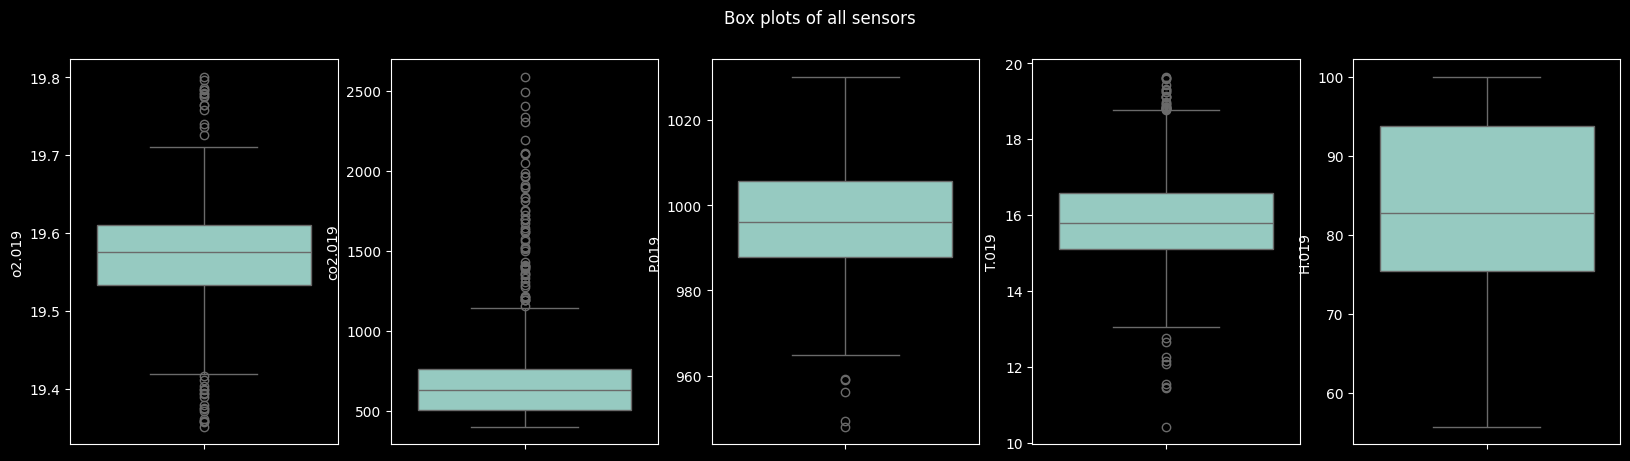

In [45]:
# definition of the set of sensors for further modelling
sensors = ['o2.019', 'co2.019', 'P.019', 'T.019', 'H.019']

# plotting box plots of each type of sensor
plt.figure(figsize=(20, 5))

for i, sensor in enumerate(sensors, start=1):
    plt.subplot(1, 5, i)
    sns.boxplot(data=data_sensors_19[sensor])

plt.suptitle('Box plots of all sensors')

Text(0.5, 0.98, 'Line plots of all sensors')

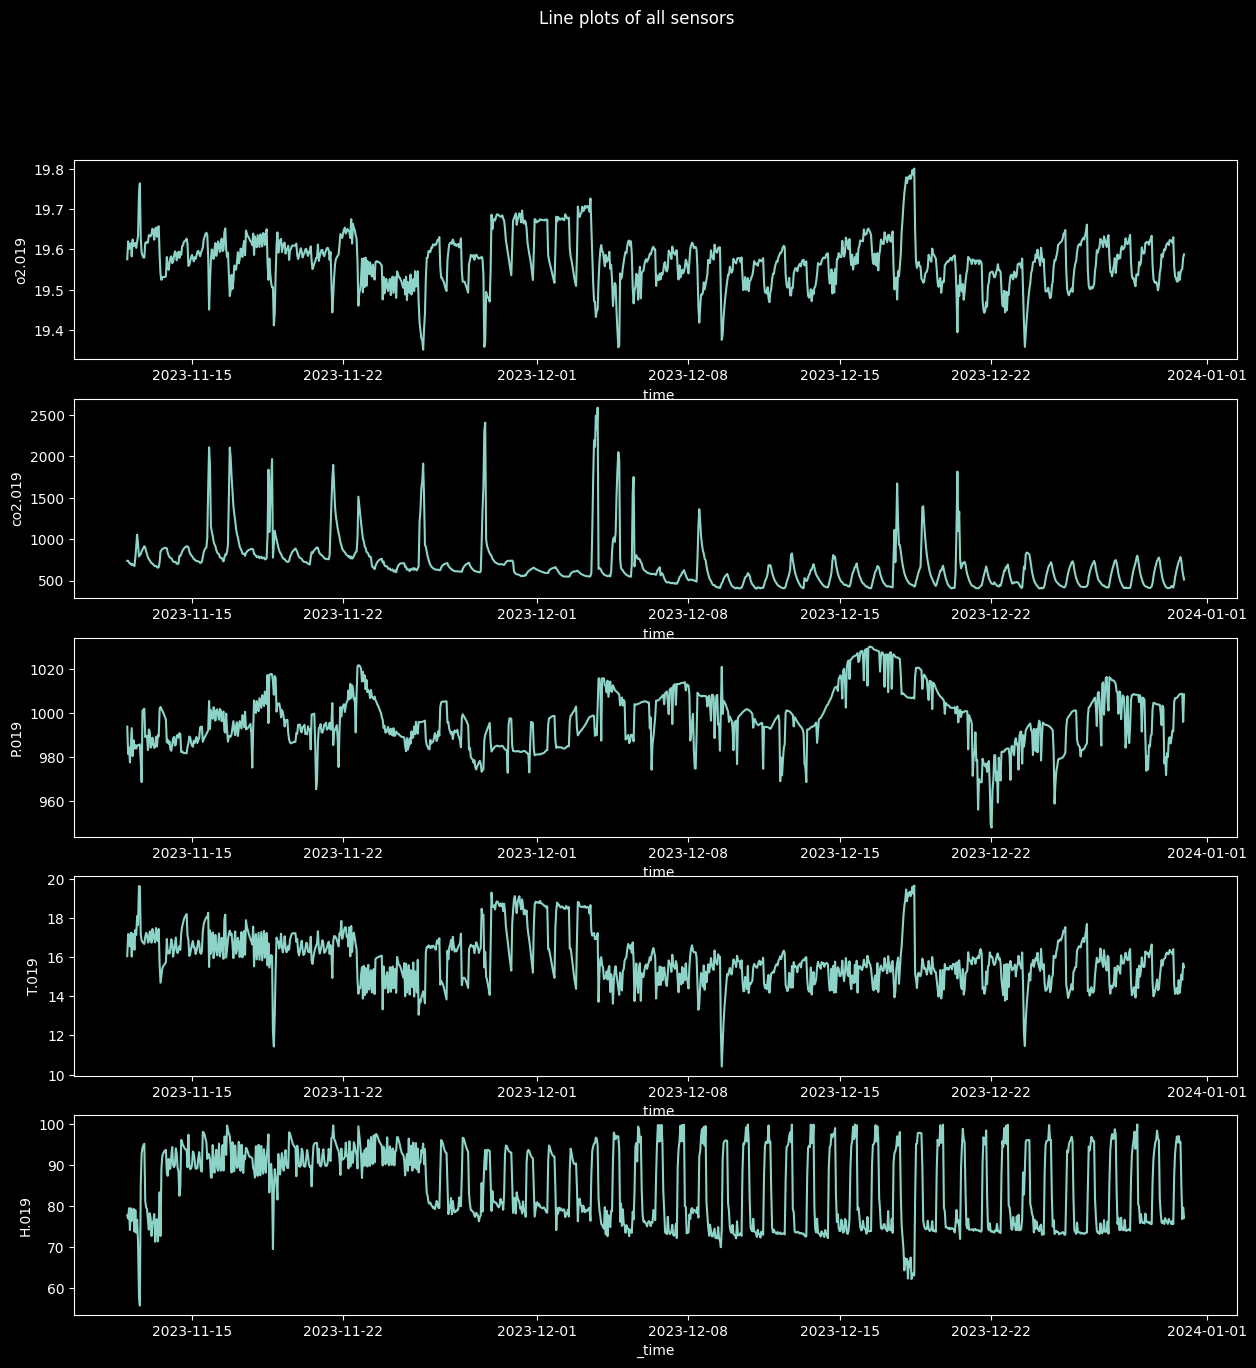

In [46]:
# plotting line plots of each type of sensor
plt.figure(figsize=(15, 15))

for i, sensor in enumerate(sensors, start=1):
    plt.subplot(5, 1, i)
    sns.lineplot(data=data_sensors_19[sensor])
    
plt.suptitle('Line plots of all sensors')

Text(0.5, 0.98, 'Line plots of all sensors, last 2 days')

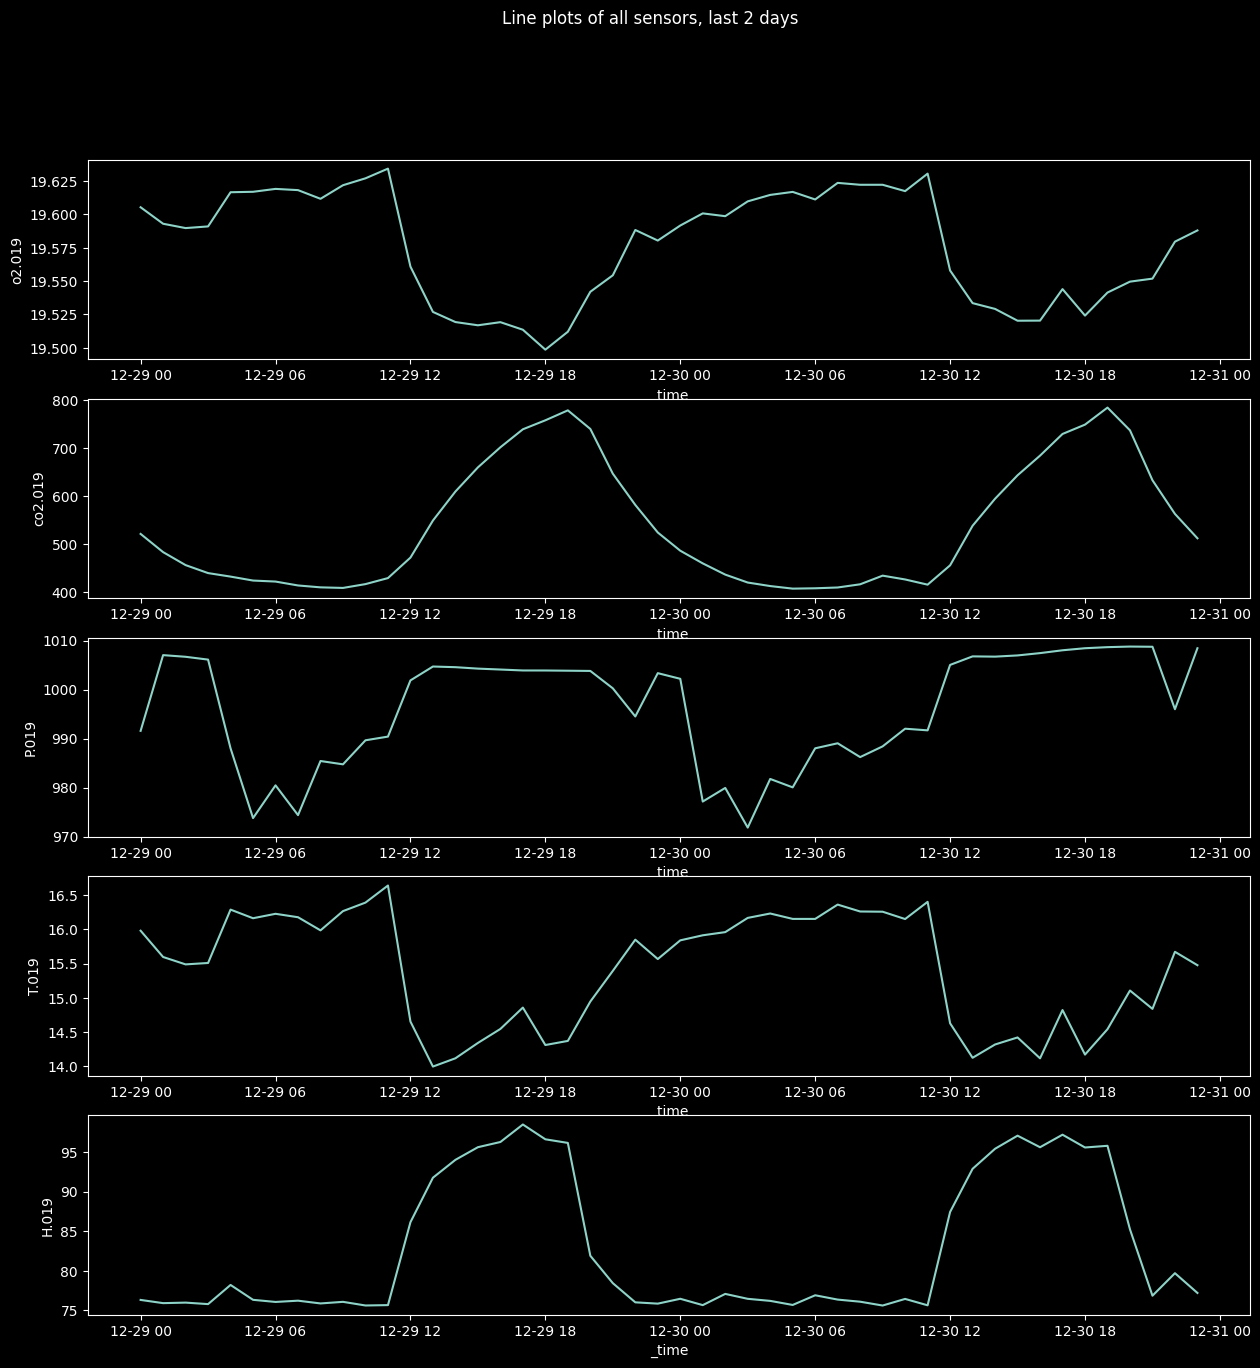

In [47]:
# plotting line plots of each type of sensor during last 2 days period (to see day's seasonality)
plt.figure(figsize=(15, 15))

for i, sensor in enumerate(sensors, start=1):
    plt.subplot(5, 1, i)
    sns.lineplot(data=data_sensors_19[sensor].tail(48))
    
plt.suptitle('Line plots of all sensors, last 2 days')

Text(0.5, 0.98, 'Histograms of all sensors')

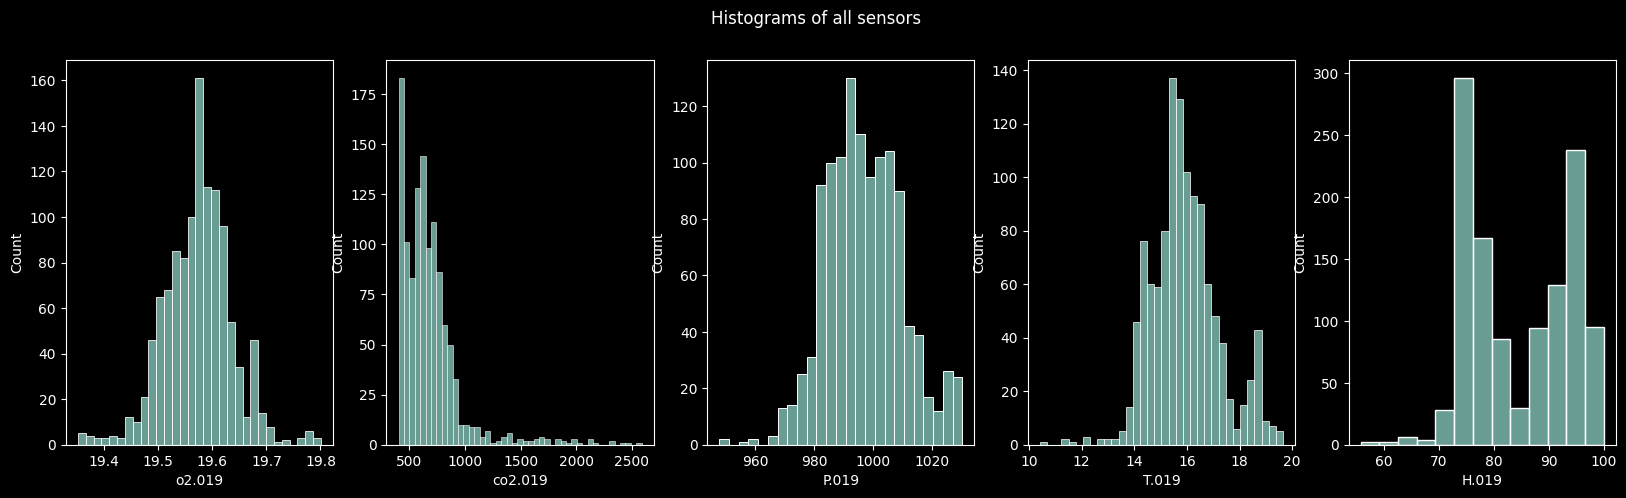

In [48]:
# checking out the histograms of each type of sensor
plt.figure(figsize=(20, 5))

for i, sensor in enumerate(sensors, start=1):
    plt.subplot(1, 5, i)
    sns.histplot(data=data_sensors_19[sensor])
    
plt.suptitle('Histograms of all sensors')

After checking the distributions, it can be concluded  that the data from each type of sensor does not have a normal distribution, resulting in the inability to use the “Simple Multivatiate Gaussian Anomaly Detection” model at a later stage of the project.

Text(0.5, 1.0, 'Pairplot of all kinds of sensors in point 19')

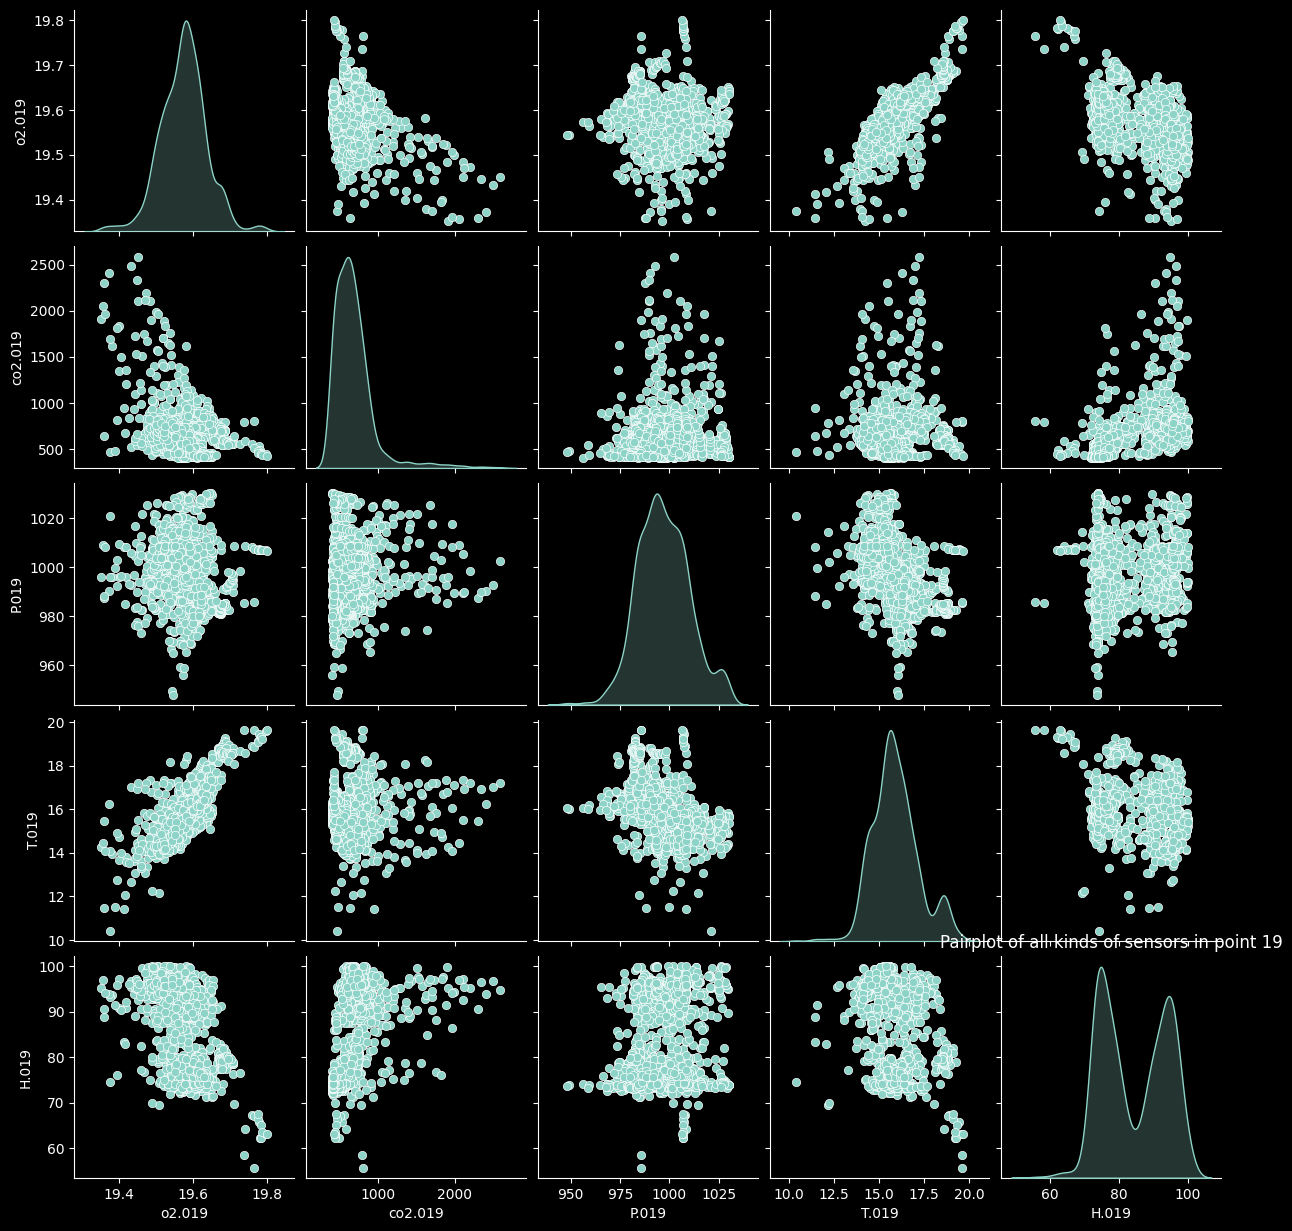

In [49]:
# checking for correlations between all the sensors
sns.pairplot(data_sensors_19, diag_kind='kde')
plt.title('Pairplot of all kinds of sensors in point 19')

<Axes: xlabel='nodeID', ylabel='nodeID'>

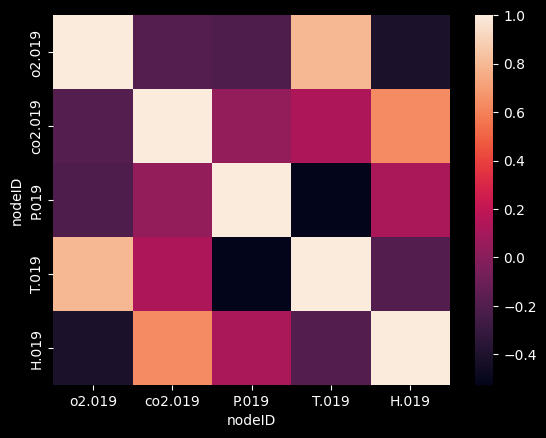

In [50]:
# checking for the correlation values
f_19_corr = data_sensors_19.corr(method='spearman')

# plotting of the correlation matrix
sns.heatmap(f_19_corr)

In [51]:
# statistical testing of the correlation between temperature and oxygen level
pingouin.corr(data_sensors_19['T.019'], data_sensors_19['o2.019'], method='spearman')  # there is a correlation

n        r         CI95%          p-val  power
spearman  1176  0.79648  [0.77, 0.82]  9.202598e-259    1.0

There is a medium positive linear correlation between temperature and oxygen levels in the air, which is strongly correlated with the process of plant vegetation. 

## Decomposition of the particular sensors data

Text(0.5, 0.98, 'Seasonal decomposition (additive) of o2 sensor')

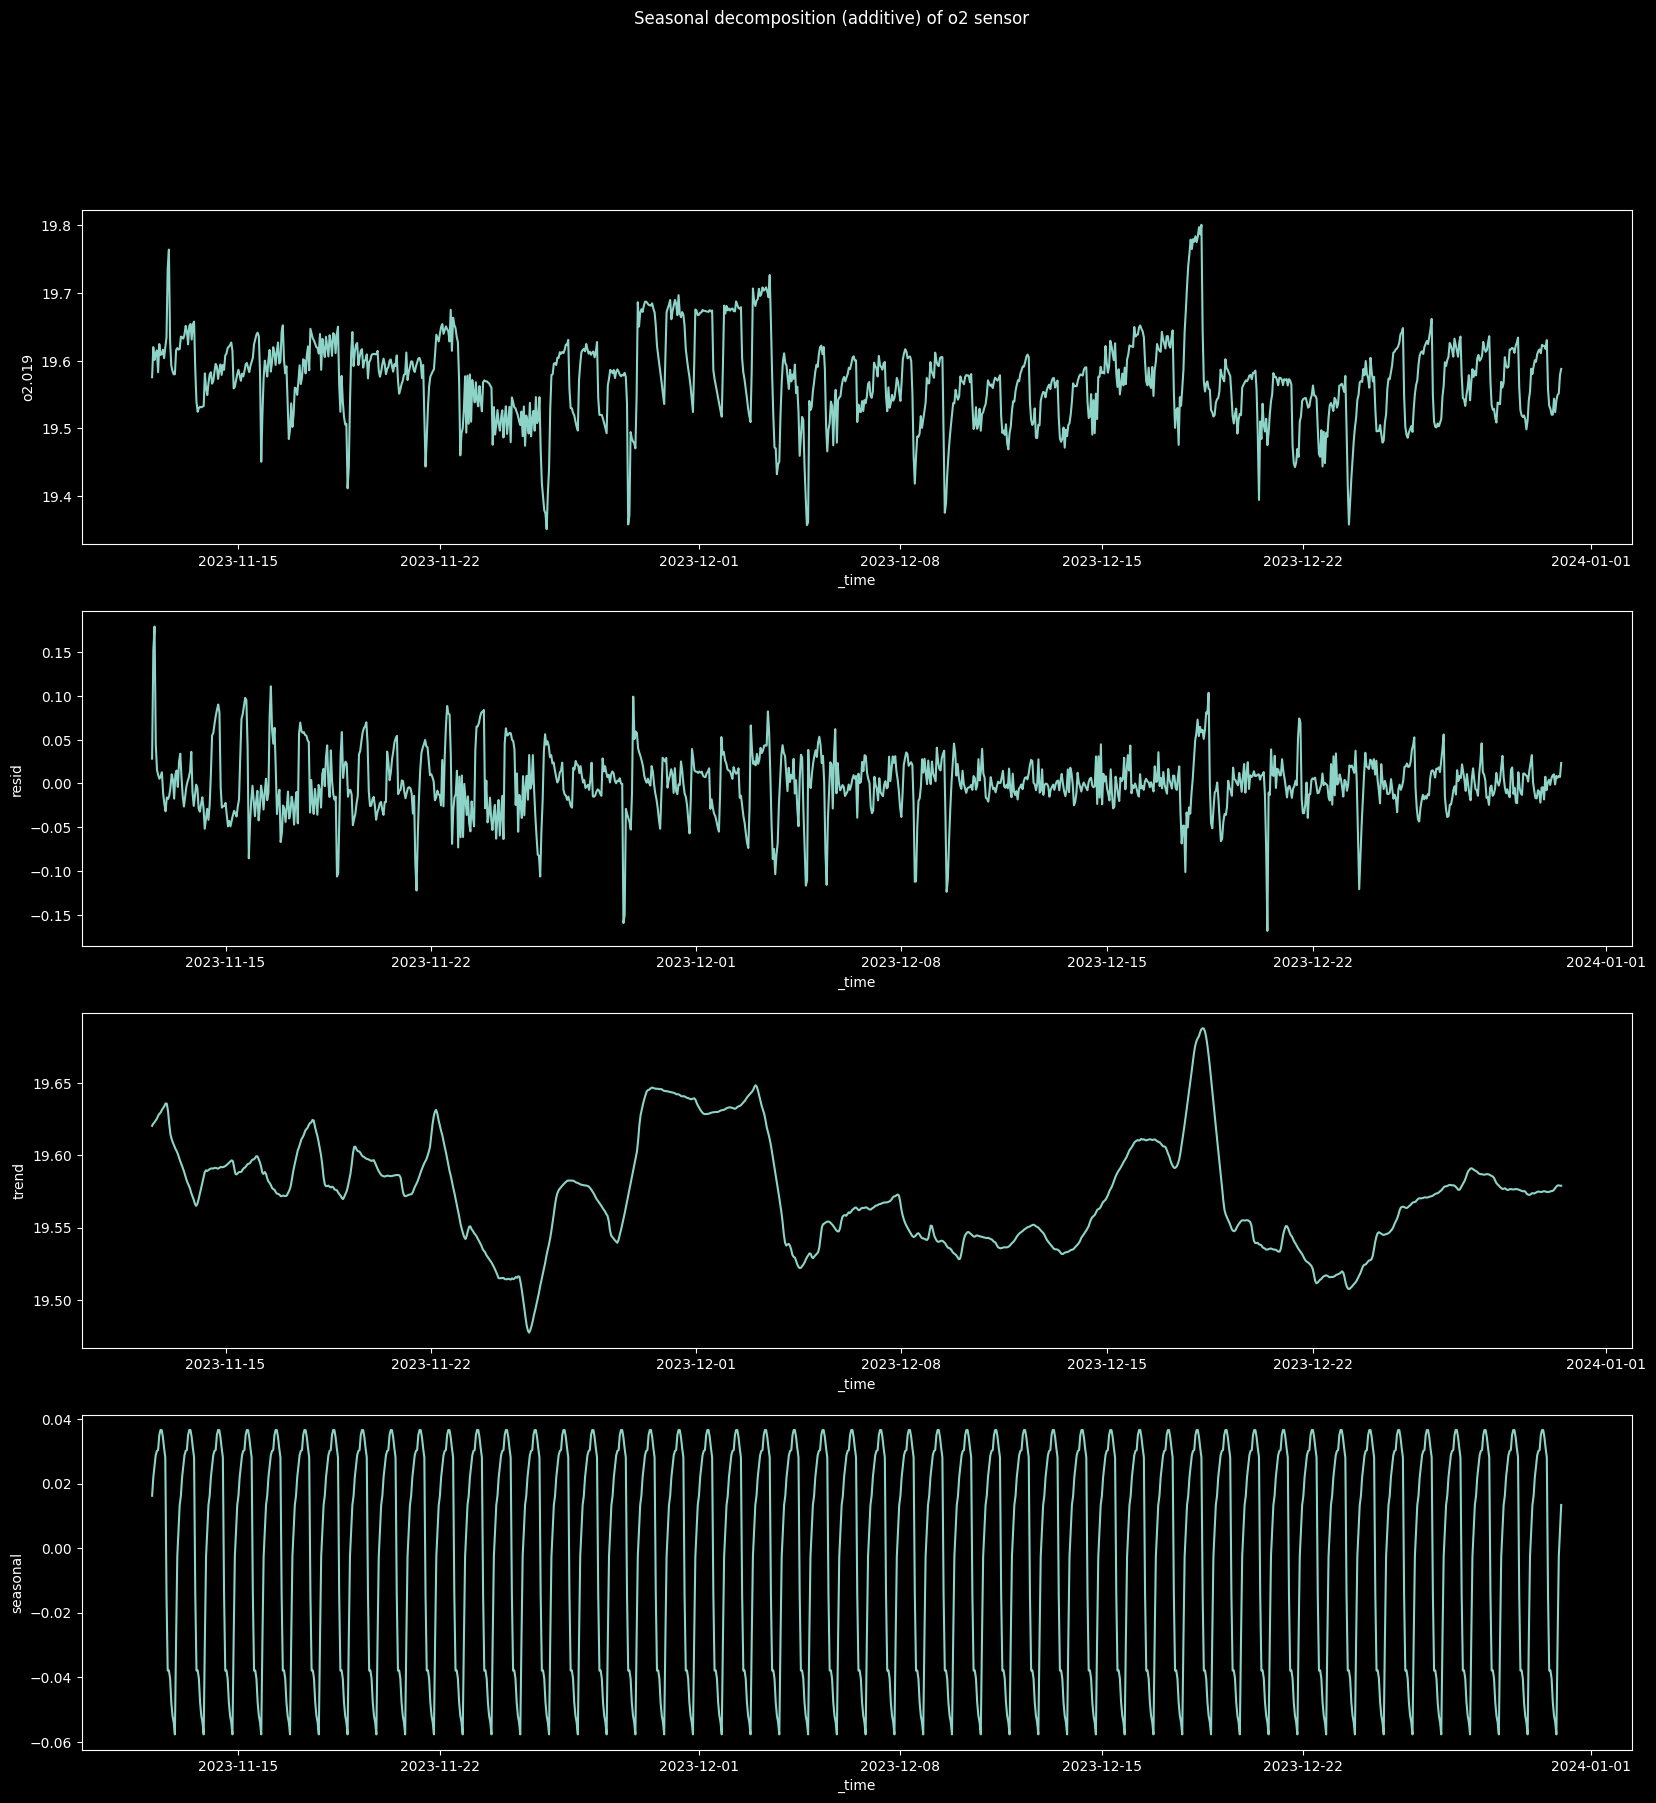

In [52]:
# seasonal decomposition of the oxygen level data
result_o2 = seasonal_decompose(data_sensors_19['o2.019'], model = 'additive')

# plotting of all seasonal decomposition components
components_o2 = [result_o2.observed, result_o2.resid, result_o2.trend, result_o2.seasonal]

plt.figure(figsize=(20, 20))

for i, component in enumerate(components_o2, start = 1):
    plt.subplot(4, 1, i)
    sns.lineplot(component)
    
plt.suptitle('Seasonal decomposition (additive) of o2 sensor')

Text(0.5, 0.98, 'Seasonal decomposition (additive) of co2 sensor')

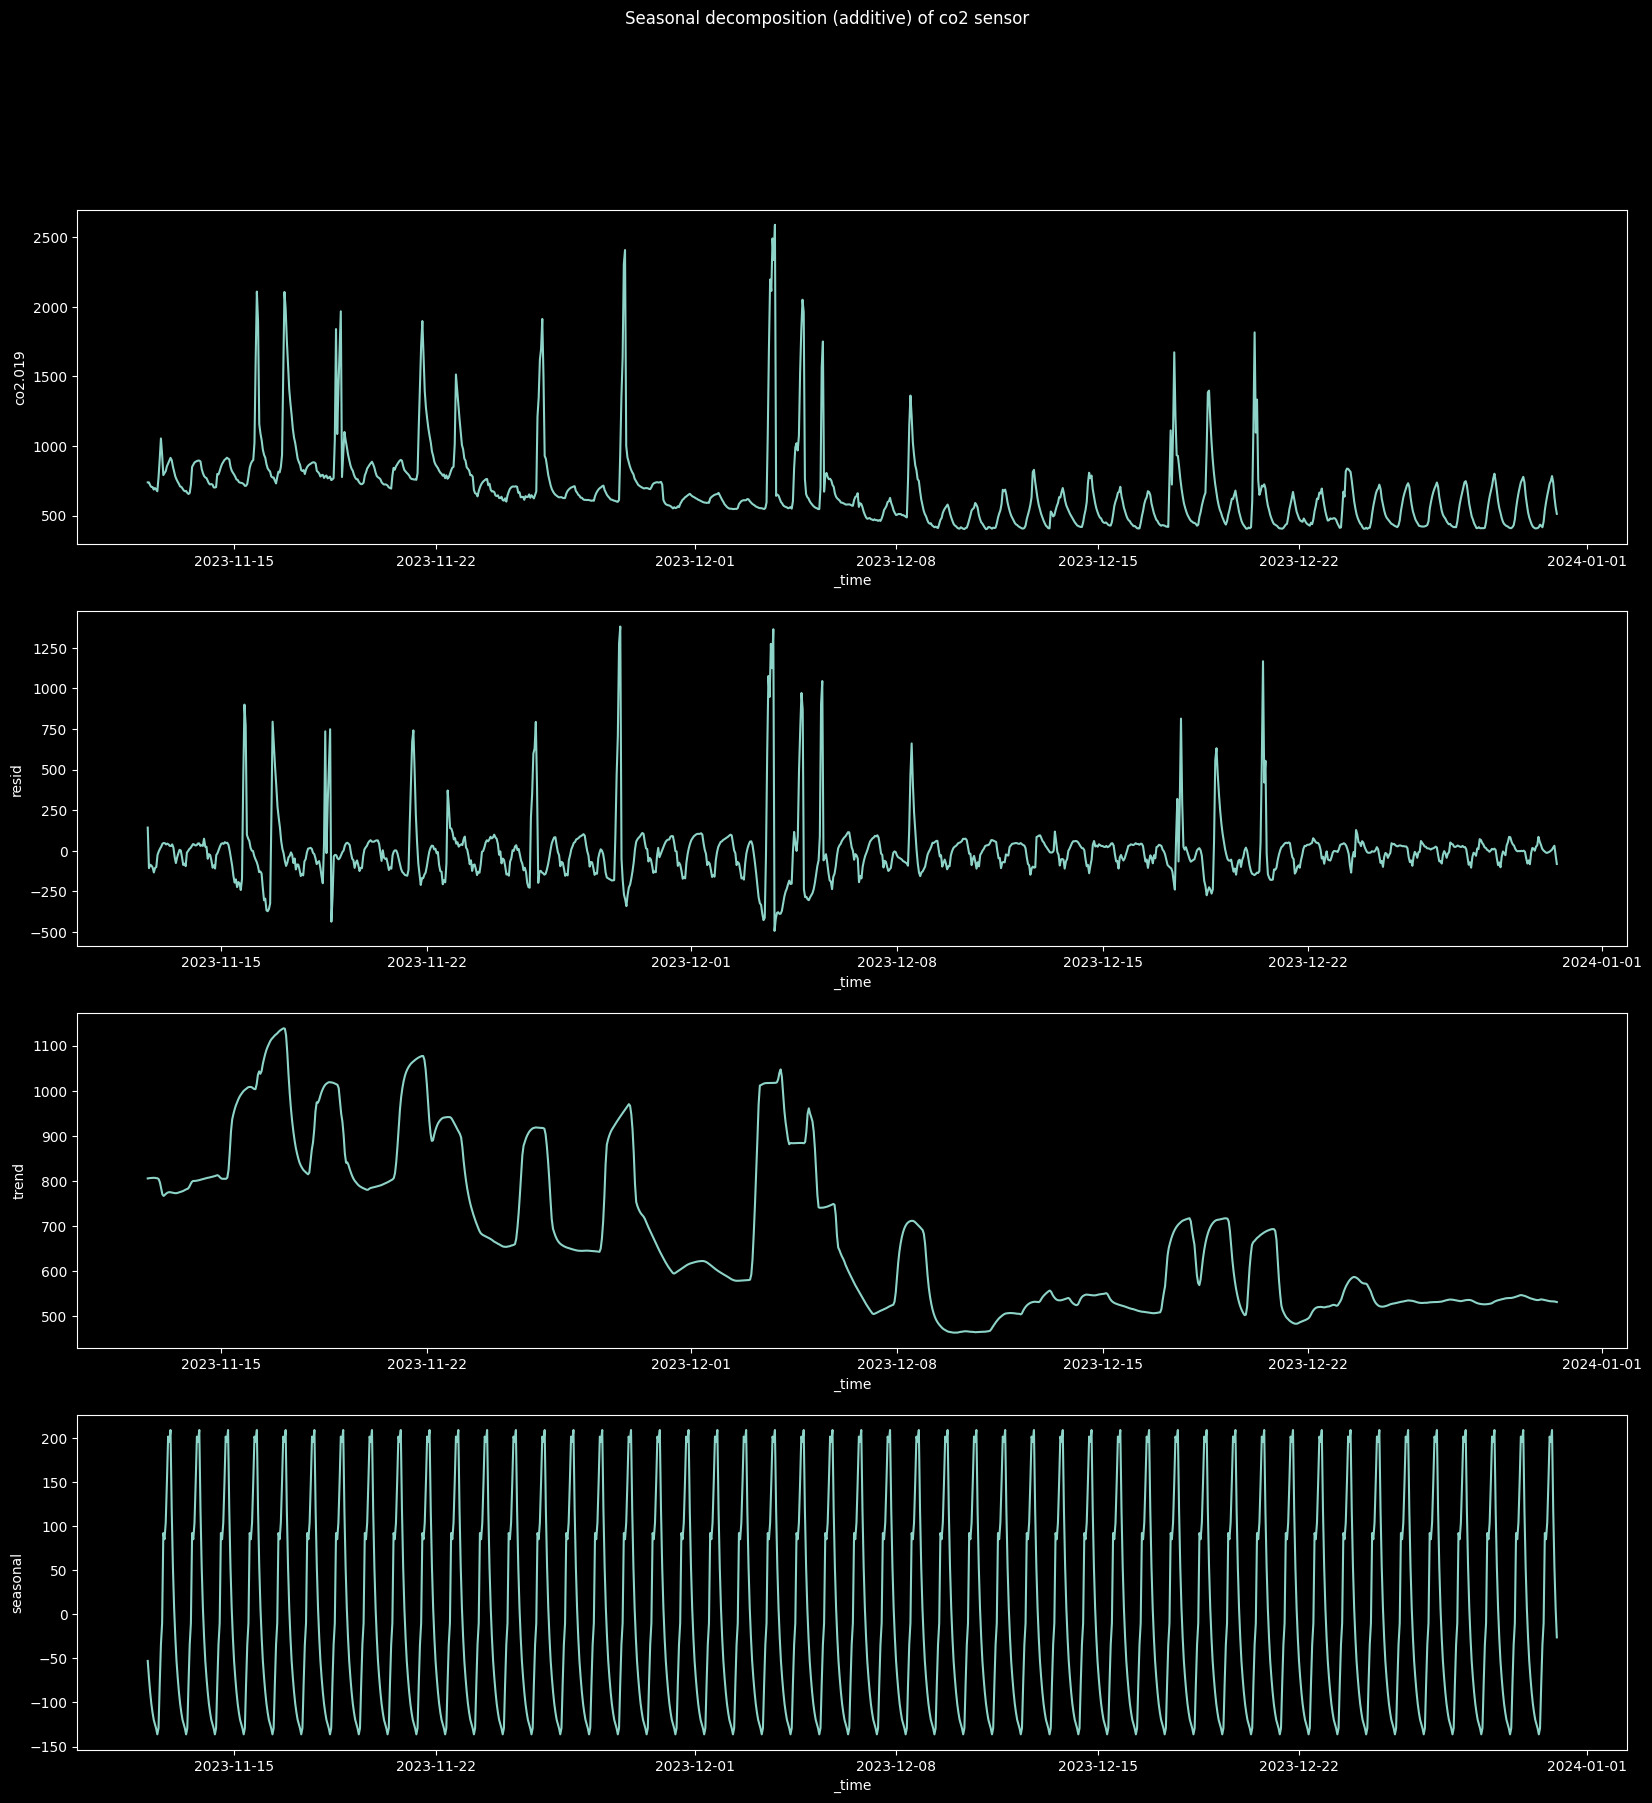

In [53]:
# seasonal decomposition of the carbon dioxide level data

result_co2 = seasonal_decompose(data_sensors_19['co2.019'], model = 'additive')

# plotting of all seasonal decomposition components
components_co2 = [result_co2.observed, result_co2.resid, result_co2.trend, result_co2.seasonal]

plt.figure(figsize=(20, 20))

for i, component in enumerate(components_co2, start = 1):
    plt.subplot(4, 1, i)
    sns.lineplot(component)
    
plt.suptitle('Seasonal decomposition (additive) of co2 sensor')

Text(0.5, 0.98, 'Seasonal decomposition (additive) of pressure sensor')

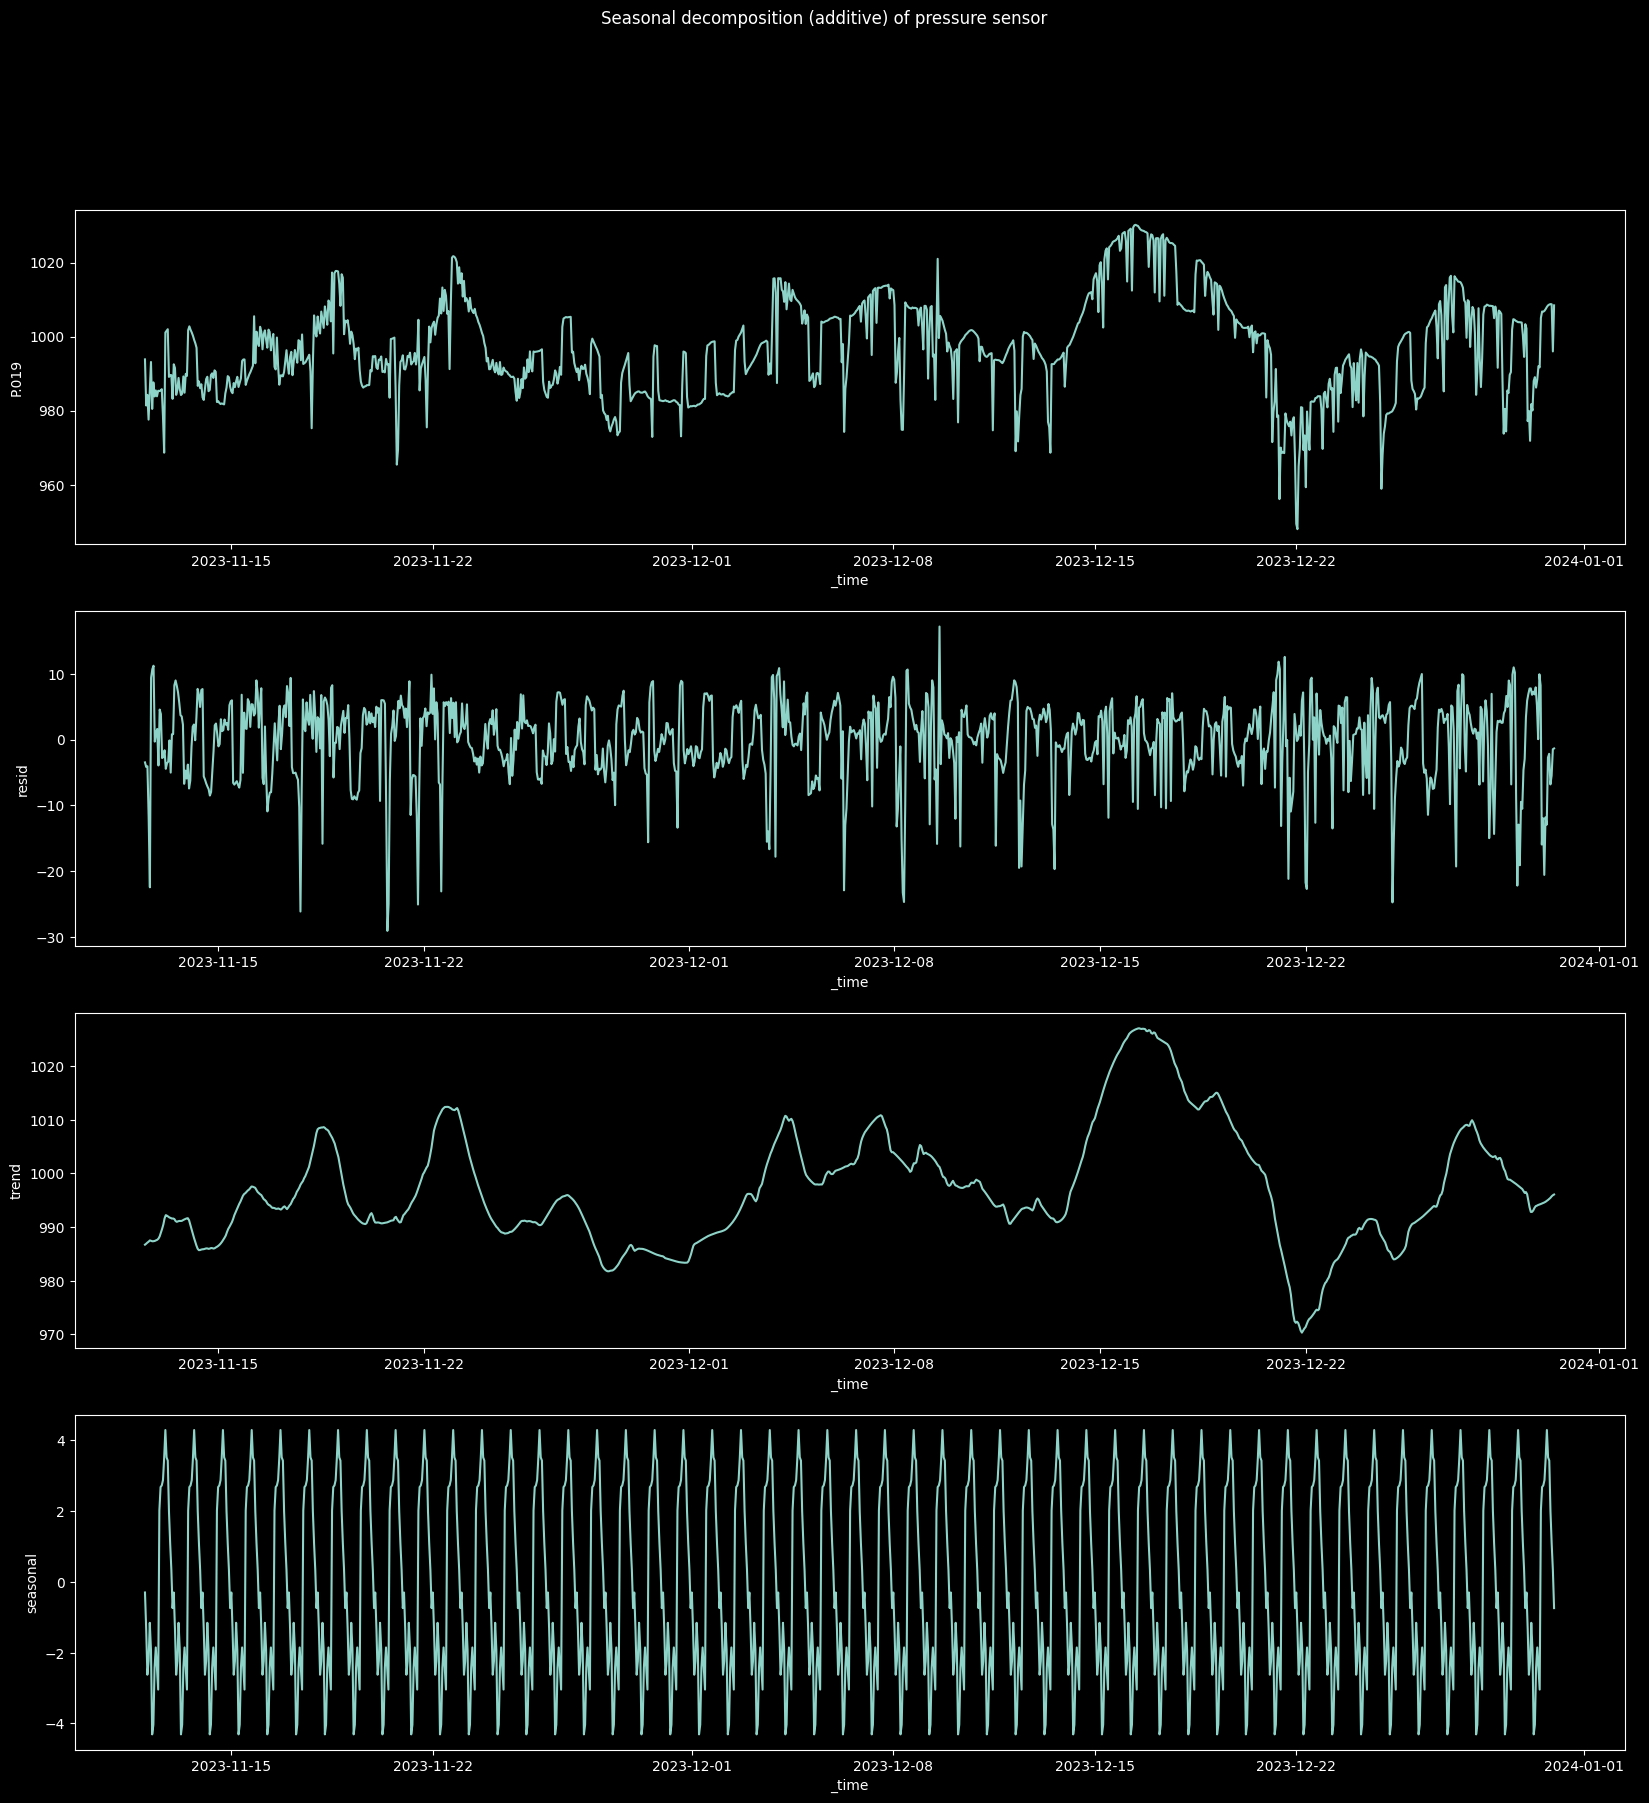

In [54]:
# seasonal decomposition of the atm pressure data
result_p = seasonal_decompose(data_sensors_19['P.019'], model = 'additive')

# plotting of all seasonal decomposition components
components_p = [result_p.observed, result_p.resid, result_p.trend, result_p.seasonal]

plt.figure(figsize=(20, 20))

for i, component in enumerate(components_p, start = 1):
    plt.subplot(4, 1, i)
    sns.lineplot(component)
    
plt.suptitle('Seasonal decomposition (additive) of pressure sensor')

Text(0.5, 0.98, 'Seasonal decomposition (additive) of temperature sensor')

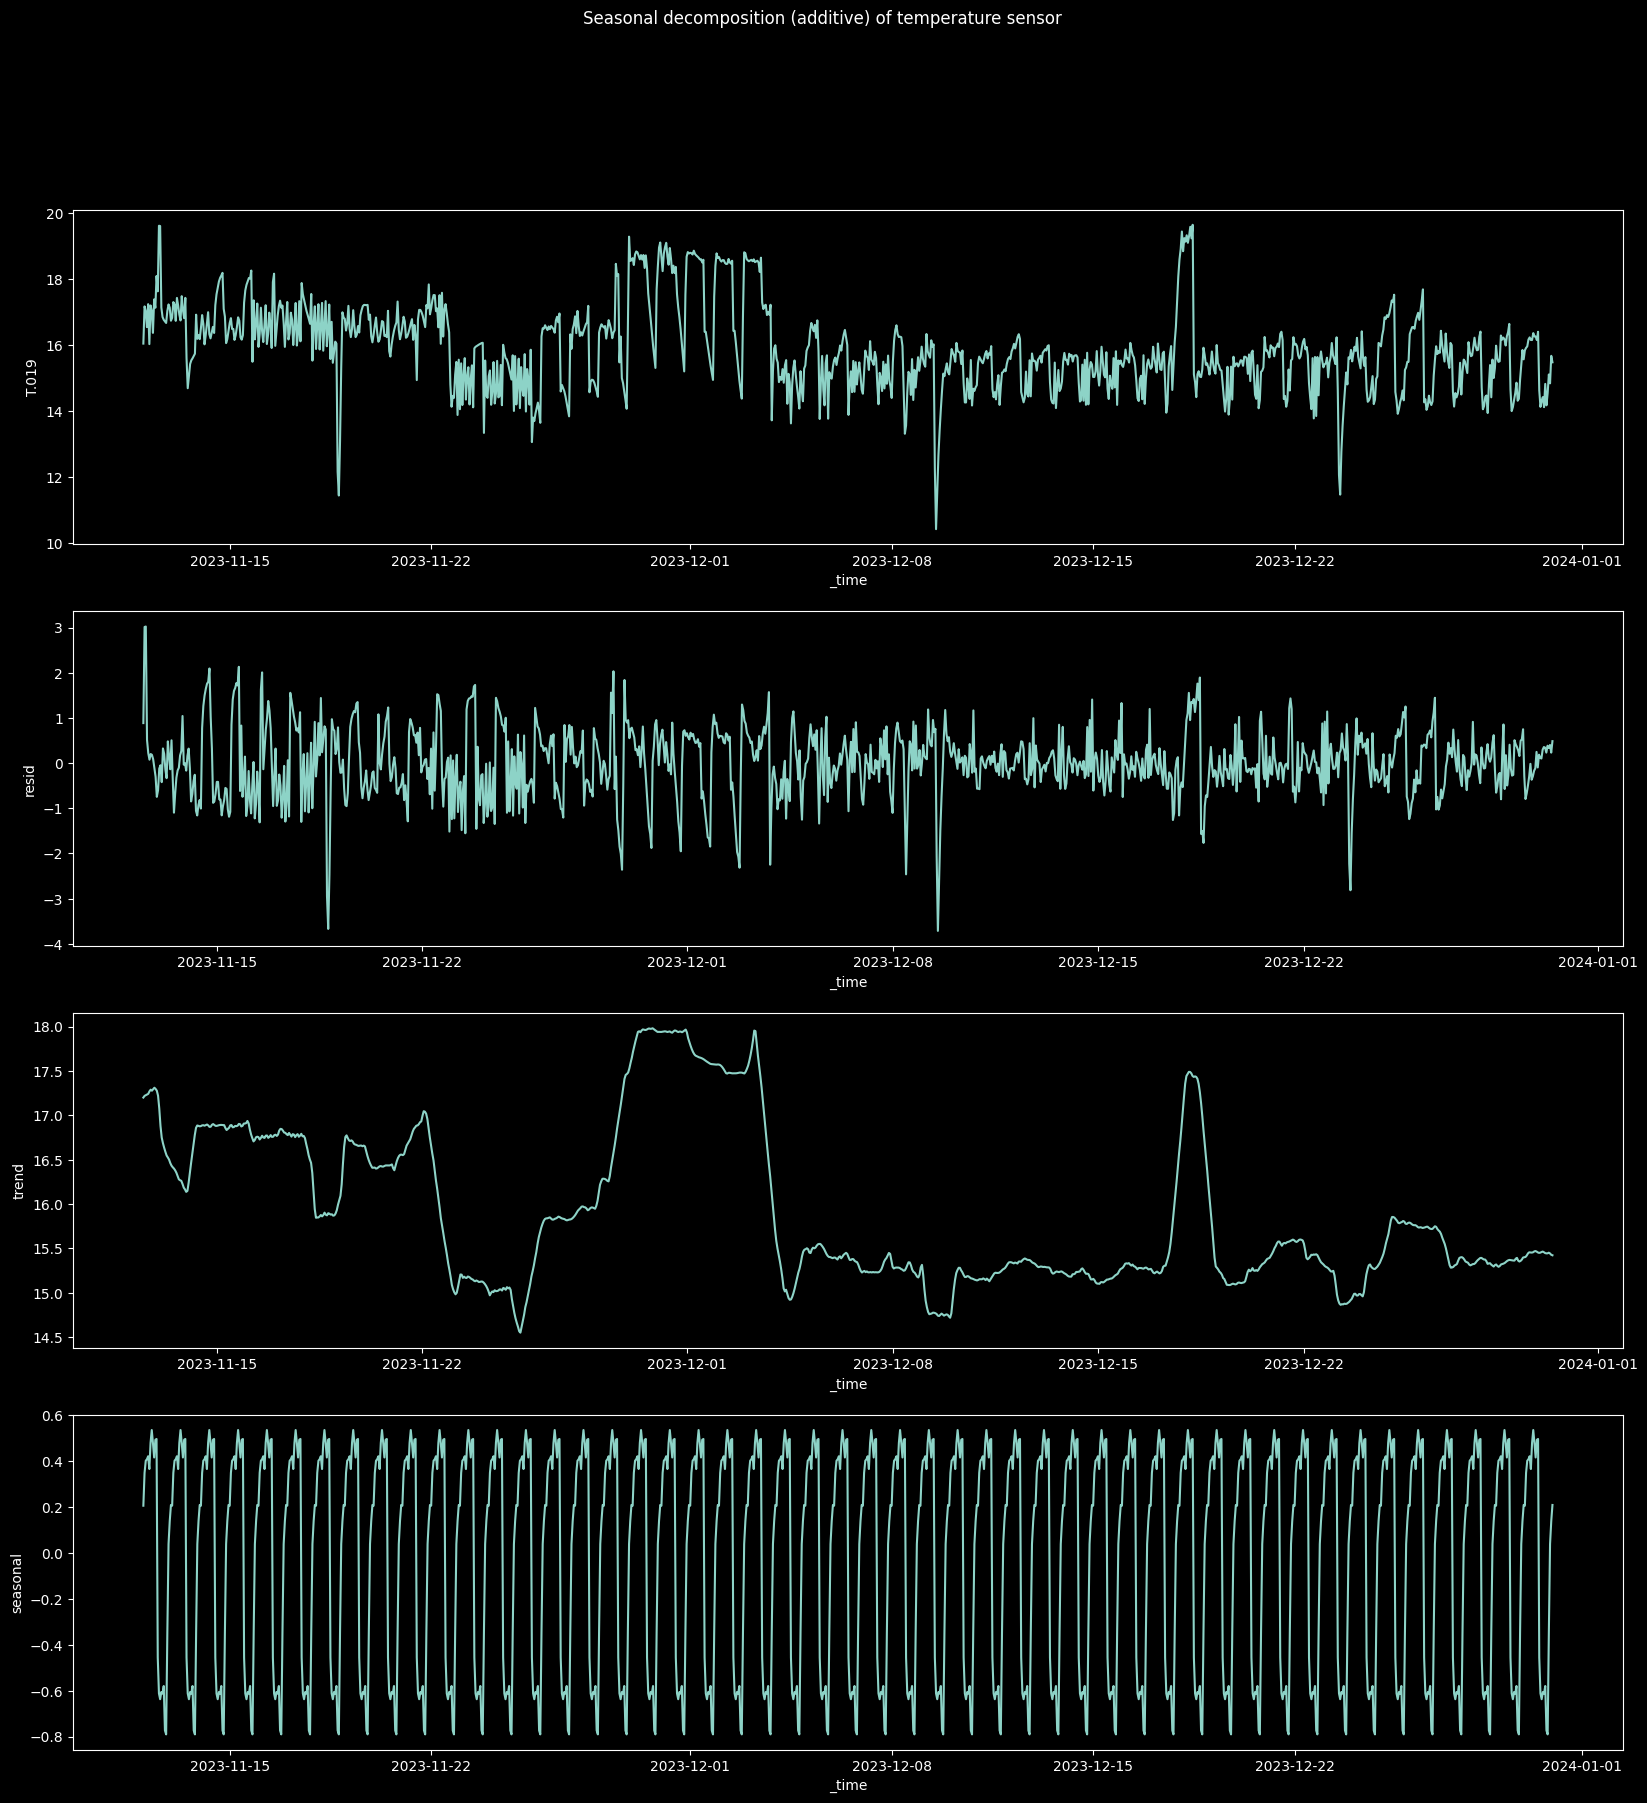

In [55]:
# seasonal decomposition of the temperature data
result_t = seasonal_decompose(data_sensors_19['T.019'], model = 'additive')

# plotting of all seasonal decomposition components
components_t = [result_t.observed, result_t.resid, result_t.trend, result_t.seasonal]

plt.figure(figsize=(20, 20))

for i, component in enumerate(components_t, start = 1):
    plt.subplot(4, 1, i)
    sns.lineplot(component)
    
plt.suptitle('Seasonal decomposition (additive) of temperature sensor')

Text(0.5, 0.98, 'Seasonal decomposition (additive) of humidity sensor')

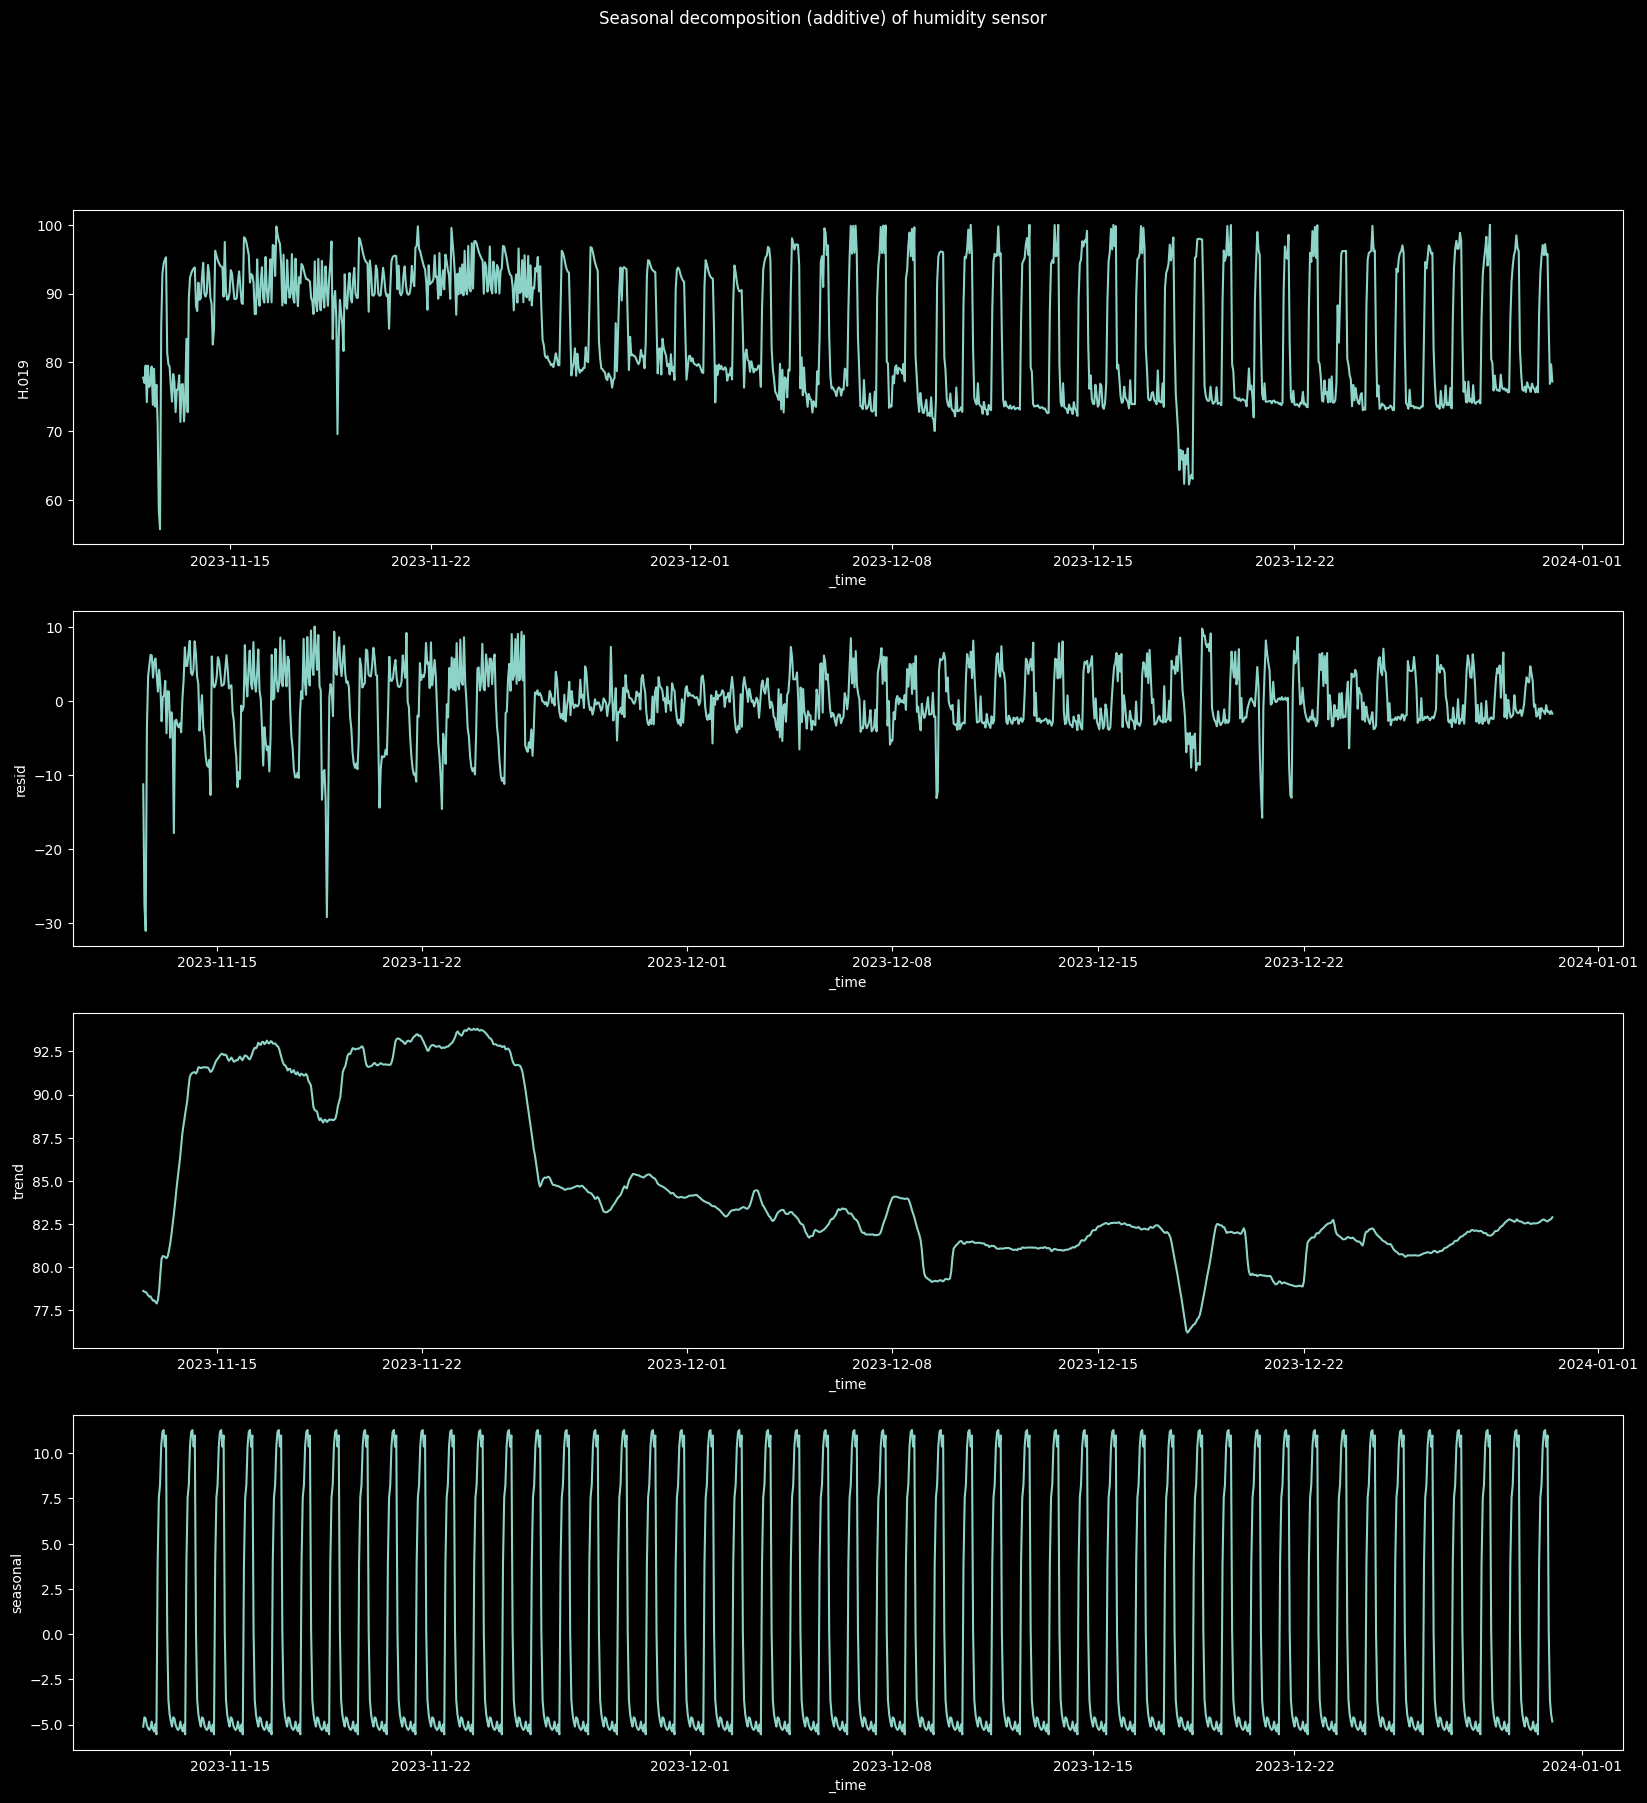

In [56]:
# seasonal decomposition of the humidity data
result_h = seasonal_decompose(data_sensors_19['H.019'], model = 'additive')

# plotting of all seasonal decomposition components
components_h = [result_h.observed, result_h.resid, result_h.trend, result_h.seasonal]

plt.figure(figsize=(20, 20))

for i, component in enumerate(components_h, start = 1):
    plt.subplot(4, 1, i)
    sns.lineplot(component)
    
plt.suptitle('Seasonal decomposition (additive) of humidity sensor')

**EDA conclusions at point 19**: No missing values were observed on any of the sensors at the point, the distributions of each sensor correspond to the distributions at other measurement points. Anomalous values are observed on each sensor, data distributions do not show normality, and there is a positive medium correlation between air temperature and oxygen content in the air. Data from all sensors show strong seasonality - characteristic daily fluctuations of the vegetation cycle, no obvious trends. Anomalies on the o2, T, H and P sensors are related to both plant processes and the ventilation/heating system itself. On the other hand, the anomalies seen on the co2 sensor are a direct result of moments of worker presence in the container (a rapid increase in co2 levels). These are actually the two types of anomalies we want to “catch” with the model.

# Modelling

The project's goal of developing a method to detect anomalies in multivariate time series type data, in the absence of data labs, can be refined as **unsupervised multivariate anomaly detection**.

After conducting preliminary data analysis (EDA) and reviewing the distributions of individual sensor data at the measurement point, the possibility of using normal-year based anomaly detection models such as ElipticEnvelope or Simple Multivatiate Gaussian Anomaly Detection was rejected.

Given the above, I chose to test unsupervised learning models that identify anomalies as significant deviations from the majority of the data, and are dedicated to multivariate datasets (not necessarily just time series). In what follows, I will focus on the models:

- Isolation Forest (iForest)
- Local Outlier Factor
- One-Class SVM

In addition, I will test an anomaly detection method dedicated to time series data - predicting the series for the period under study, and comparing the prediction with the current data, thus exposing anomalies. From there, I will additionally test the Prophet model, separately applied to each series, and combine the results with a logic gate.

- Prophet

From preliminary information coming from the data and from conversations with people working in the container, it was determined that the maximum level of anomaly we want to detect with the models is 10%. 

In [57]:
data = data_sensors_19
data.describe()

nodeID       o2.019      co2.019        P.019        T.019        H.019
count   1176.000000  1176.000000  1176.000000  1176.000000  1176.000000
mean      19.573317   683.279616   997.073332    15.914719    84.468749
std        0.062336   283.759787    12.992369     1.282655     9.374908
min       19.351333   402.258333   947.955833    10.414500    55.700000
25%       19.533479   504.060417   987.910000    15.112604    75.360208
50%       19.576125   629.754167   995.982500    15.777292    82.708750
75%       19.610604   762.437500  1005.689375    16.579062    93.798750
max       19.800750  2589.941667  1030.209167    19.646917   100.000000

## Isolation Forest

In [58]:
# definition of the subset of sensors for further modelling
sensors = ['o2.019', 'co2.019', 'T.019', 'H.019', 'P.019']

In [59]:
# iForest basic model with 10% of anomalies detection level
clf_if = IsolationForest(random_state=123, contamination=0.1)
clf_if.fit(data[sensors])

IsolationForest(contamination=0.1, random_state=123)

In [60]:
data['anomaly_value_if'] = clf_if.predict(data[sensors])

In [61]:
data.anomaly_value_if.value_counts()

anomaly_value_if
 1    1058
-1     118
Name: count, dtype: int64

Let's visualize all the sensors one by one to see if the model caught all the “anomalous” peaks on each sensor. For the moment, this is the only way to evaluate the models' performance.

Text(0.5, 1.0, 'Anomalies detected on o2 sensor with iForest')

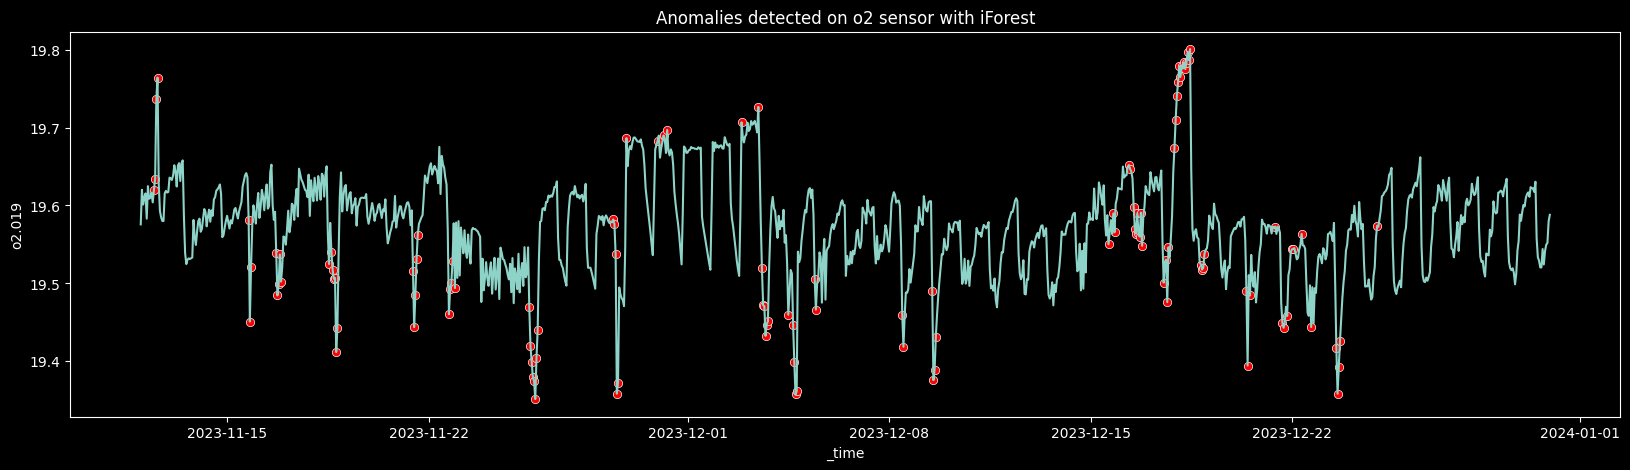

In [62]:
# plotting of the anomalies detected with iForest on o2 sensor data
anomaly_if=data.loc[data['anomaly_value_if']==-1]
plt.figure(figsize = (20,5))
sns.lineplot(data, x = data.index, y = 'o2.019')
sns.scatterplot(anomaly_if, x = anomaly_if.index, y = 'o2.019', color = 'red')
plt.title('Anomalies detected on o2 sensor with iForest')

Text(0.5, 1.0, 'Anomalies detected on co2 sensor with iForest')

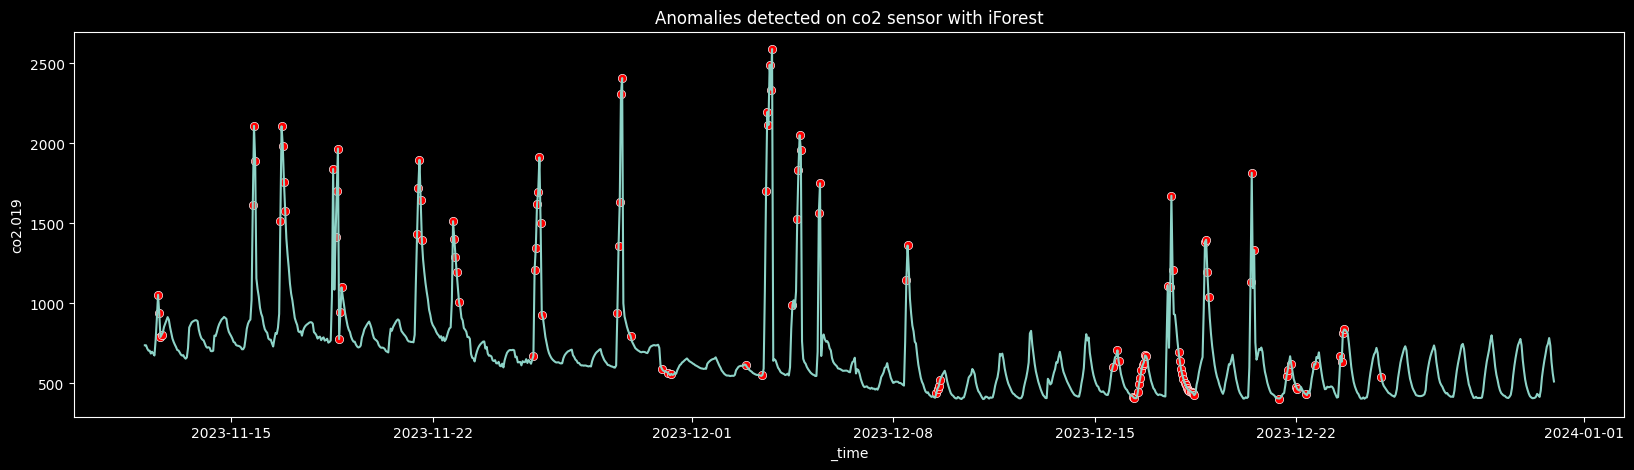

In [63]:
# plotting of the anomalies detected with iForest on co2 sensor data
plt.figure(figsize = (20,5))
sns.lineplot(data, x = data.index, y = 'co2.019')
sns.scatterplot(anomaly_if, x = anomaly_if.index, y = 'co2.019', color = 'red')
plt.title('Anomalies detected on co2 sensor with iForest')

Text(0.5, 1.0, 'Anomalies detected on T sensor with iForest')

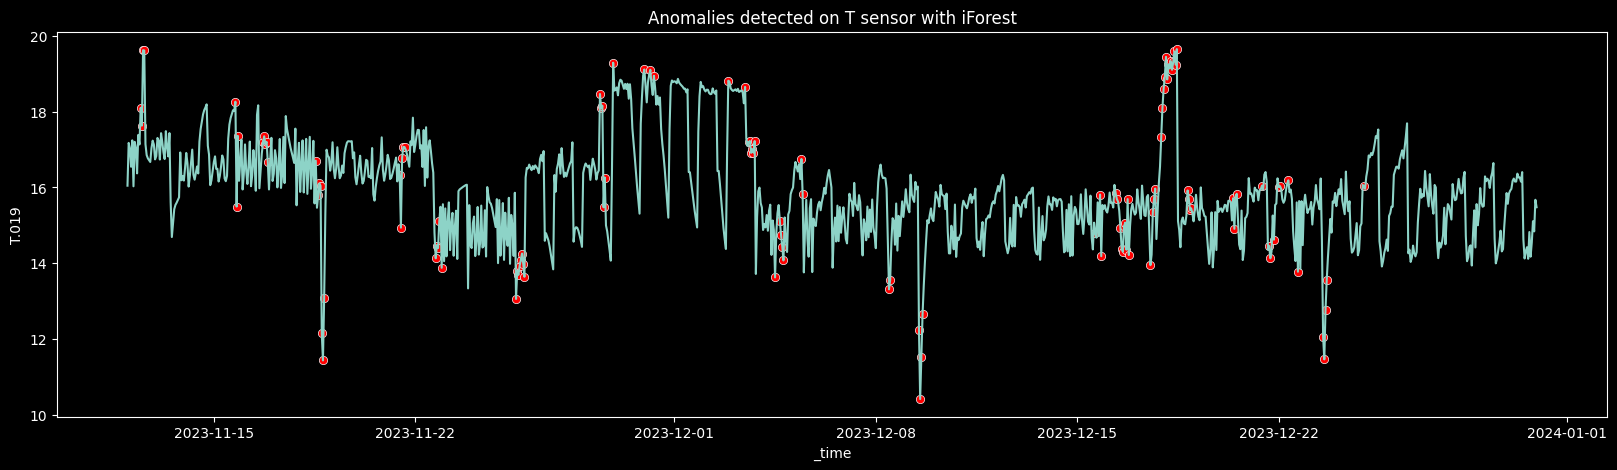

In [64]:
# plotting of the anomalies detected with iForest on T sensor data
plt.figure(figsize = (20,5))
sns.lineplot(data, x = data.index, y = 'T.019')
sns.scatterplot(anomaly_if, x = anomaly_if.index, y = 'T.019', color = 'red')
plt.title('Anomalies detected on T sensor with iForest')

Text(0.5, 1.0, 'Anomalies detected on H sensor with iForest')

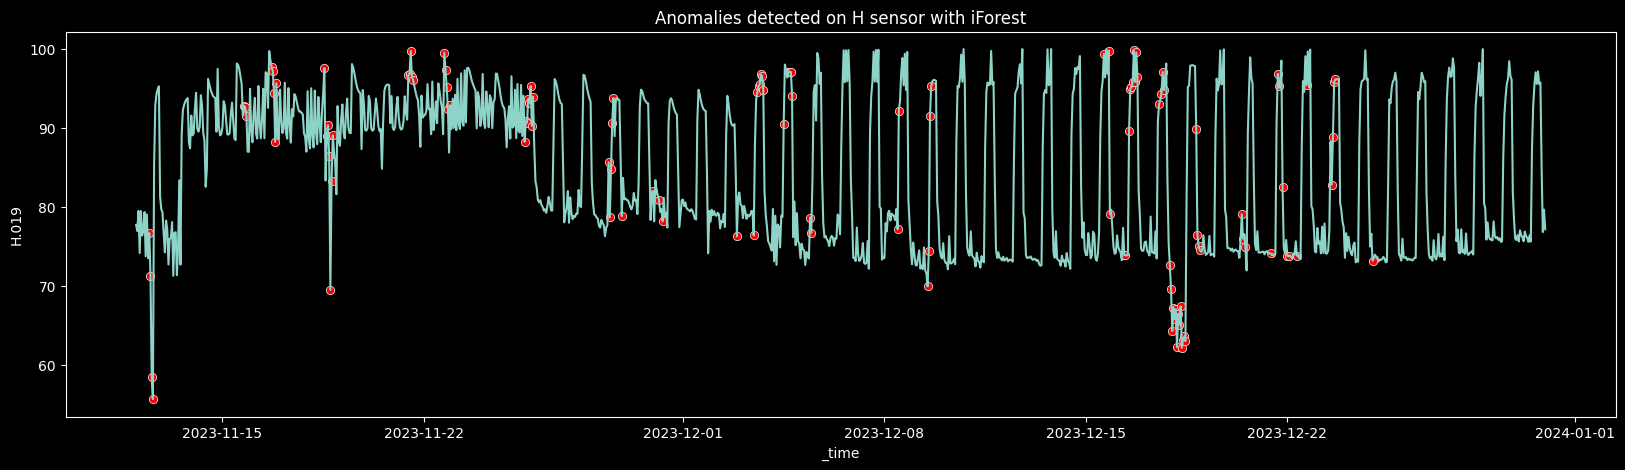

In [65]:
# plotting of the anomalies detected with iForest on H sensor data
plt.figure(figsize = (20,5))
sns.lineplot(data, x = data.index, y = 'H.019')
sns.scatterplot(anomaly_if, x = anomaly_if.index, y = 'H.019', color = 'red')
plt.title('Anomalies detected on H sensor with iForest')

Visually, the model looks quite good.

## Local Outlier Factor

In [66]:
# LOF basic model with 10% of anomalies detection level + MinMaxScaler for data scaling
clf_lof_pipeline = make_pipeline(
    MinMaxScaler(), 
    LocalOutlierFactor(contamination=0.1, novelty=False)
)
data['anomaly_value_lof'] = clf_lof_pipeline.fit_predict(data[sensors])
data['anomaly_value_lof'].value_counts()

anomaly_value_lof
 1    1058
-1     118
Name: count, dtype: int64

Text(0.5, 1.0, 'Anomalies detected on co2 sensor with LOF')

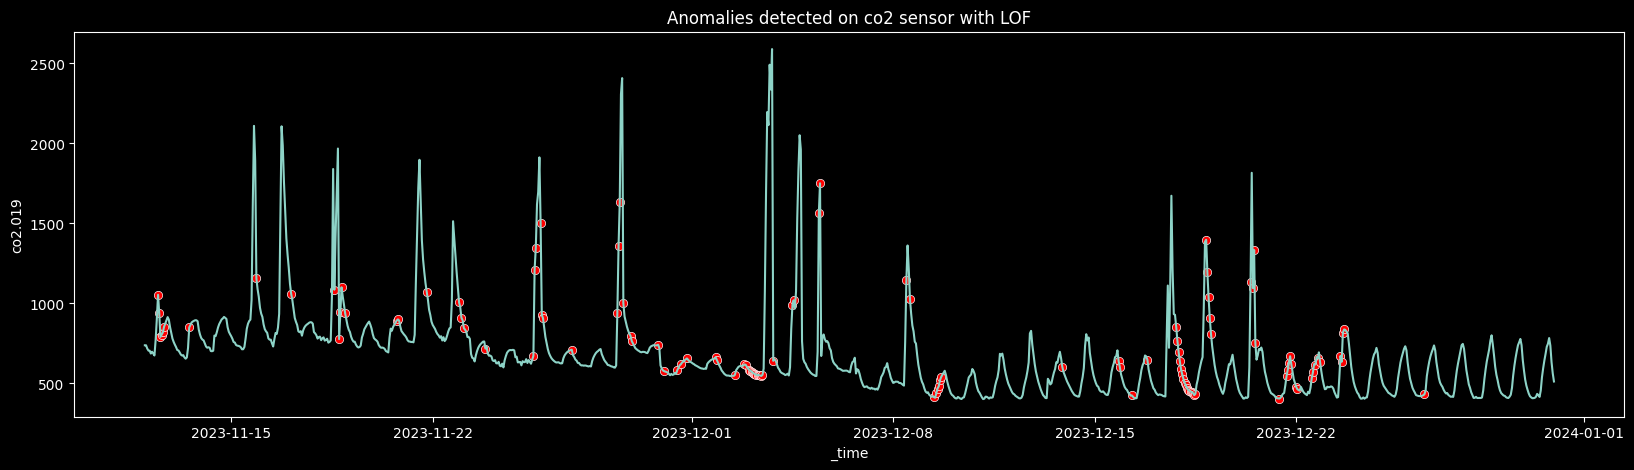

In [67]:
anomaly_lof=data.loc[data['anomaly_value_lof']==-1]
plt.figure(figsize = (20,5))
sns.lineplot(data, x = data.index, y = 'co2.019')
sns.scatterplot(anomaly_lof, x = anomaly_lof.index, y = 'co2.019', color = 'red')
plt.title('Anomalies detected on co2 sensor with LOF')

Text(0.5, 1.0, 'Anomalies detected on o2 sensor with LOF')

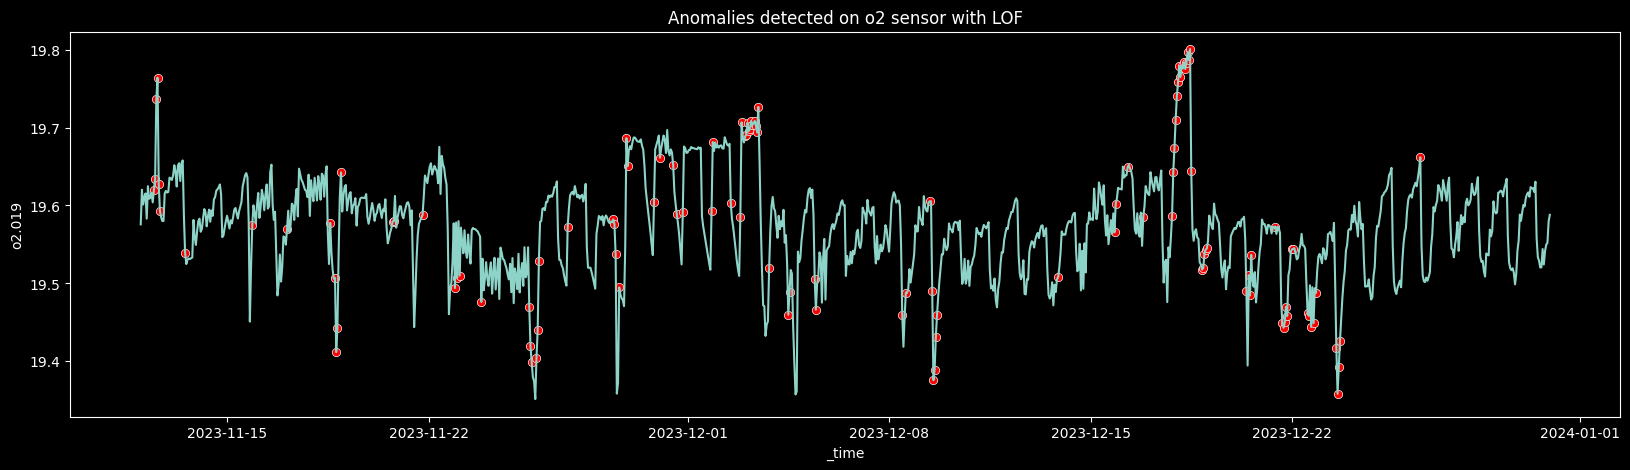

In [68]:
plt.figure(figsize = (20,5))
sns.lineplot(data, x = data.index, y = 'o2.019')
sns.scatterplot(anomaly_lof, x = anomaly_lof.index, y = 'o2.019', color = 'red')
plt.title('Anomalies detected on o2 sensor with LOF')

Text(0.5, 1.0, 'Anomalies detected on T sensor with LOF')

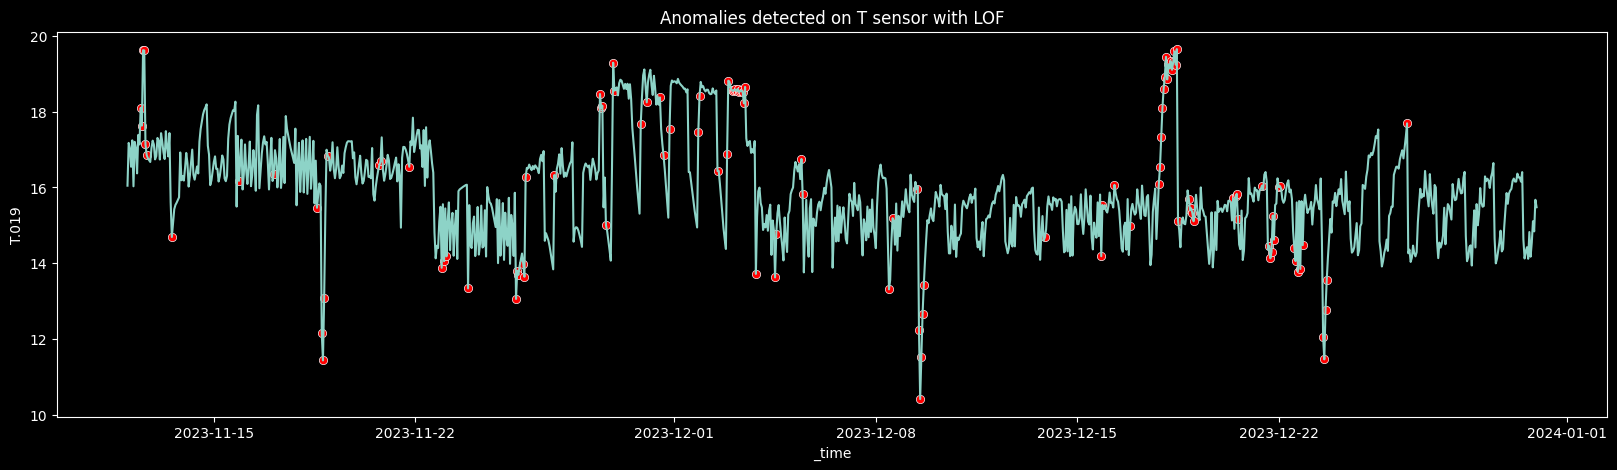

In [69]:
plt.figure(figsize = (20,5))
sns.lineplot(data, x = data.index, y = 'T.019')
sns.scatterplot(anomaly_lof, x = anomaly_lof.index, y = 'T.019', color = 'red')
plt.title('Anomalies detected on T sensor with LOF')

Text(0.5, 1.0, 'Anomalies detected on H sensor with LOF')

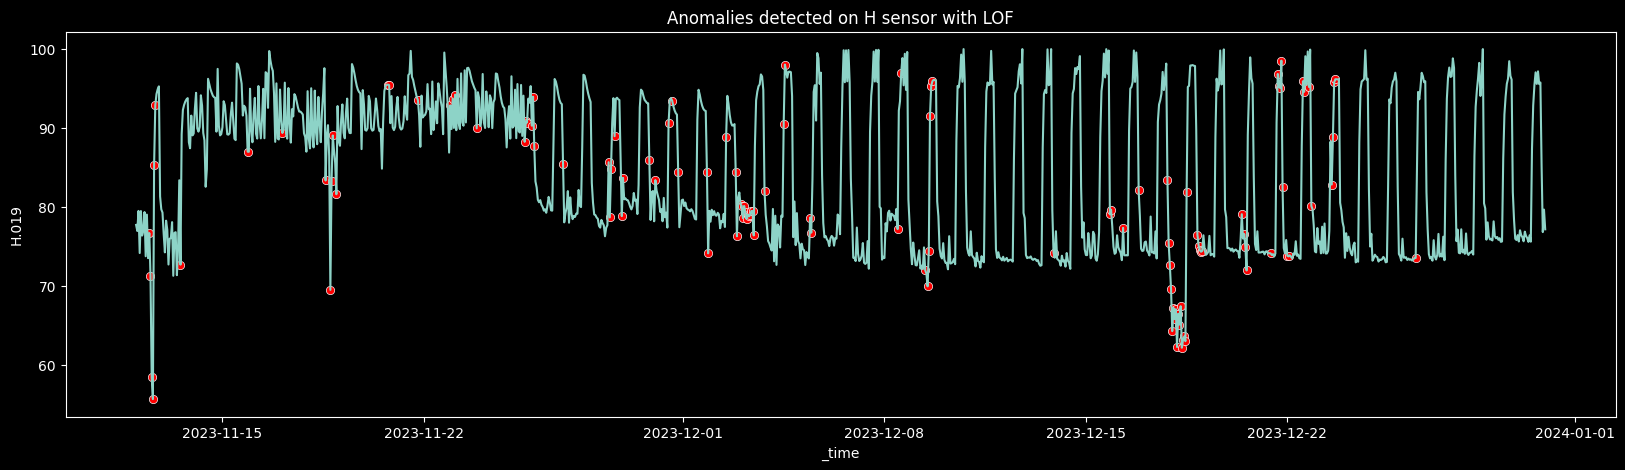

In [70]:
plt.figure(figsize = (20,5))
sns.lineplot(data, x = data.index, y = 'H.019')
sns.scatterplot(anomaly_lof, x = anomaly_lof.index, y = 'H.019', color = 'red')
plt.title('Anomalies detected on H sensor with LOF')

The model visually looks much worse than iForest.

## One-Class SVM

In [71]:
# One-Class SVM basic model with 10% of anomalies detection level + MinMaxScaler for data scaling
clf_svm_pipeline = make_pipeline(
    MinMaxScaler(), 
    OneClassSVM(nu = 0.1)
)
data['anomaly_value_svm'] = clf_svm_pipeline.fit_predict(data[sensors])

In [72]:
data['anomaly_value_svm'].value_counts()

anomaly_value_svm
 1    1059
-1     117
Name: count, dtype: int64

Text(0.5, 1.0, 'Anomalies detected on co2 sensor with SVM')

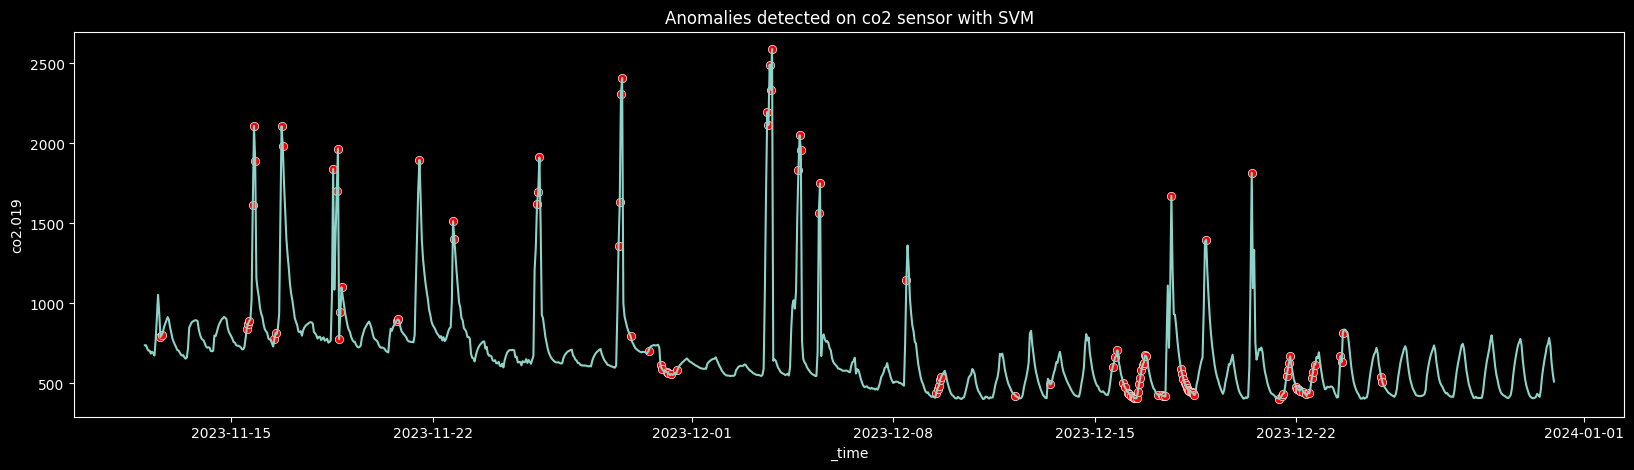

In [73]:
anomaly_svm=data.loc[data['anomaly_value_svm']==-1]
plt.figure(figsize = (20,5))
sns.lineplot(data, x = data.index, y = 'co2.019')
sns.scatterplot(anomaly_svm, x = anomaly_svm.index, y = 'co2.019', color = 'red')
plt.title('Anomalies detected on co2 sensor with SVM')

## Facebook Prophet

In [74]:
# fb prophet

data_prophet = data[sensors].reset_index() # prophet request specific form of data, without an index

def prophet_func(a):

    '''
    Function performing simple Prophet model forecasting for a chosen sensor
    '''

    # data preparation - without index, special date format, colnames 'ds' and 'y'
    df = data_prophet[['_time', f'{a}.019']]
    df.columns = ['ds', 'y']
    df['ds'] = df['ds'].astype('str')
    df['ds'] = df['ds'].str.slice(0, 19)
    df['ds'] = pd.to_datetime(df['ds'])


    # fitting basic Prophet model to data
    model = Prophet()
    model.fit(df)

    # predictions and plotting
    future = model.make_future_dataframe(periods=0, freq='H') # we're not forecating to the future, but only current time horizon
    predictions = model.predict(future)
    predictions_final = predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].join(df['y'])


    plt.style.use('classic')
    model.plot(predictions)
    plt.title('Forecast for anomaly detection - {} sensor'.format(a))
    #plot_series(df, predictions, labels= ['true', 'predicted'])
    #plt.title('Original & predicted data {}'.format(a))

    return predictions_final
    

C:\Users\vasya\AppData\Local\Temp\ipykernel_21556\3236030207.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ds'] = df['ds'].astype('str')
C:\Users\vasya\AppData\Local\Temp\ipykernel_21556\3236030207.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ds'] = df['ds'].str.slice(0, 19)
C:\Users\vasya\AppData\Local\Temp\ipykernel_21556\3236030207.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

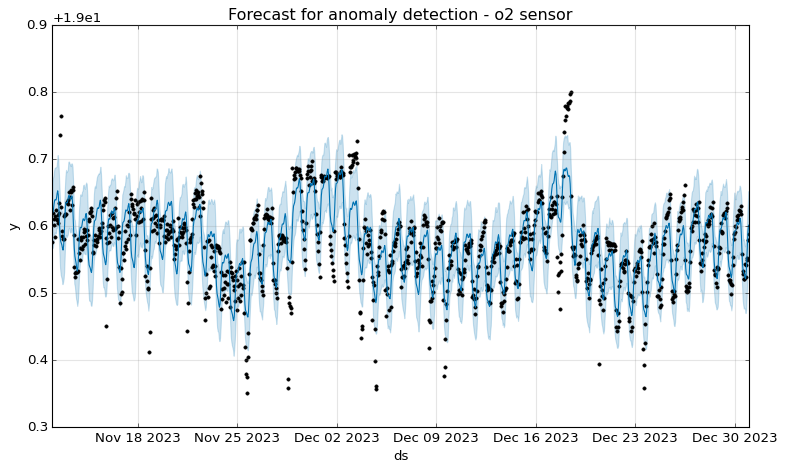

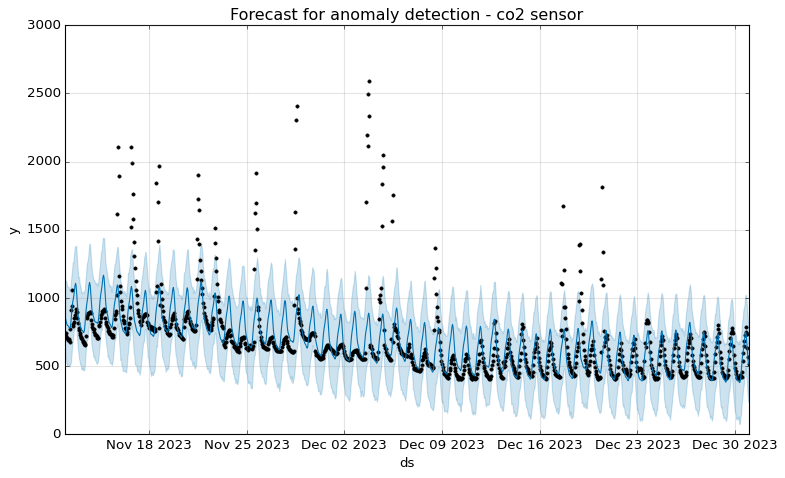

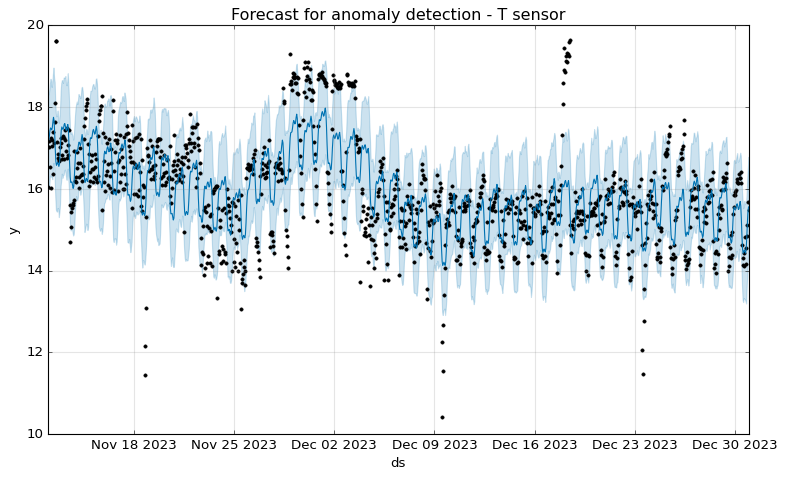

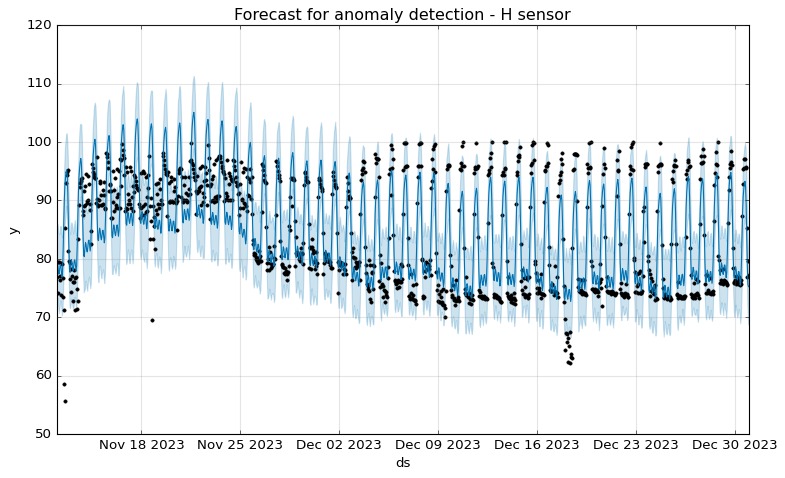

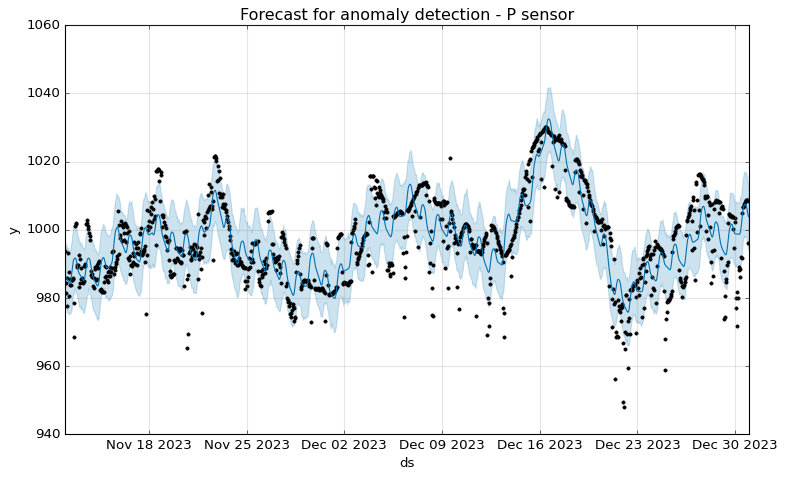

In [75]:
o2_forecast = prophet_func('o2')
co2_forecast = prophet_func('co2')
T_forecast = prophet_func('T')
H_forecast = prophet_func('H')
P_forecast = prophet_func('P')

In [76]:
# The idea is that points not hitting the 95% confidence interval of the forecast are defined as anomalies. 
# On the other hand, in that case the dataset has more than 35% anomalous values, which misses the client's assumption by 10%.
# So, I've chosen the thresholds for particular sensors the way summary amount of anomalies is 10%

def anomaly_func_t(df):
    conditions = ((df.loc[:, 'y'] < df.loc[:, 'yhat_lower'] - 1.2)
              | (df.loc[:, 'y'] > df.loc[:, 'yhat_upper'] + 1.2))
    df['anomaly'] = np.where(conditions, -1, 1)
    return df

def anomaly_func_h(df):
    conditions = ((df.loc[:, 'y'] < df.loc[:, 'yhat_lower'] - 5)
              | (df.loc[:, 'y'] > df.loc[:, 'yhat_upper'] + 5))
    df['anomaly'] = np.where(conditions, -1, 1)
    return df


def anomaly_func_co2(df):
    conditions = ((df.loc[:, 'y'] < df.loc[:, 'yhat_lower'] - 5)
              | (df.loc[:, 'y'] > df.loc[:, 'yhat_upper'] + 5))
    df['anomaly'] = np.where(conditions, -1, 1)
    return df

def anomaly_func_o2(df):
    conditions = ((df.loc[:, 'y'] < df.loc[:, 'yhat_lower'] - 0.05)
              | (df.loc[:, 'y'] > df.loc[:, 'yhat_upper'] + 0.05))
    df['anomaly'] = np.where(conditions, -1, 1)
    return df

def anomaly_func_p(df):
    conditions = ((df.loc[:, 'y'] < df.loc[:, 'yhat_lower'] - 10)
              | (df.loc[:, 'y'] > df.loc[:, 'yhat_upper'] + 10))
    df['anomaly'] = np.where(conditions, -1, 1)
    return df


T_forecast = anomaly_func_t(T_forecast)
H_forecast = anomaly_func_h(H_forecast)
co2_forecast = anomaly_func_co2(co2_forecast)
o2_forecast = anomaly_func_o2(o2_forecast)
P_forecast = anomaly_func_p(P_forecast)

In [77]:
T_forecast['anomaly'].value_counts(normalize=True)

anomaly
 1    0.979592
-1    0.020408
Name: proportion, dtype: float64

In [78]:
plt.style.use('dark_background')
def plot_anomalies(df):
    '''
    A function plotting timeseries data + anomalies 'catched' by Prophet
    '''
    plt.figure(figsize=(20,5))
    sns.lineplot(df, x = 'ds', y = 'y')
    sns.scatterplot(df[df['anomaly'] == -1], x = 'ds', y = 'y', c = 'red')

Text(0.5, 1.0, 'Pressure')

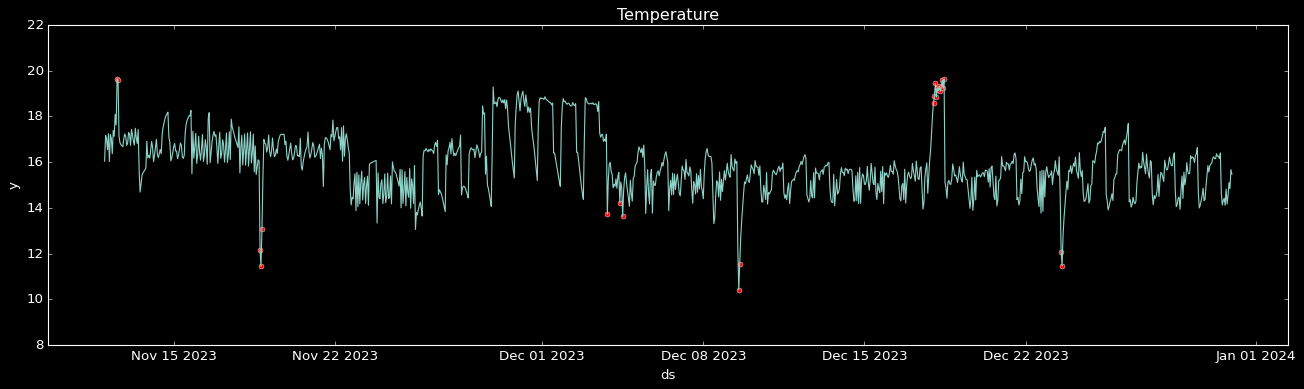

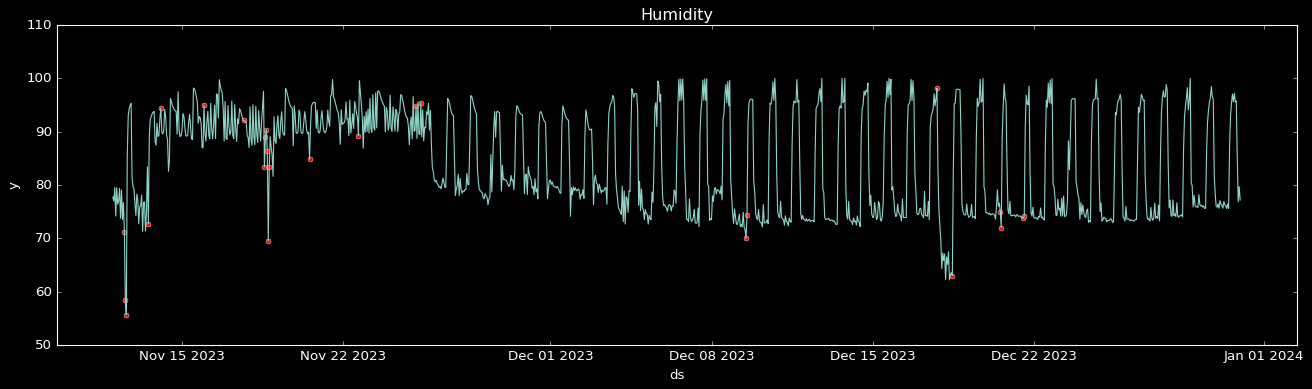

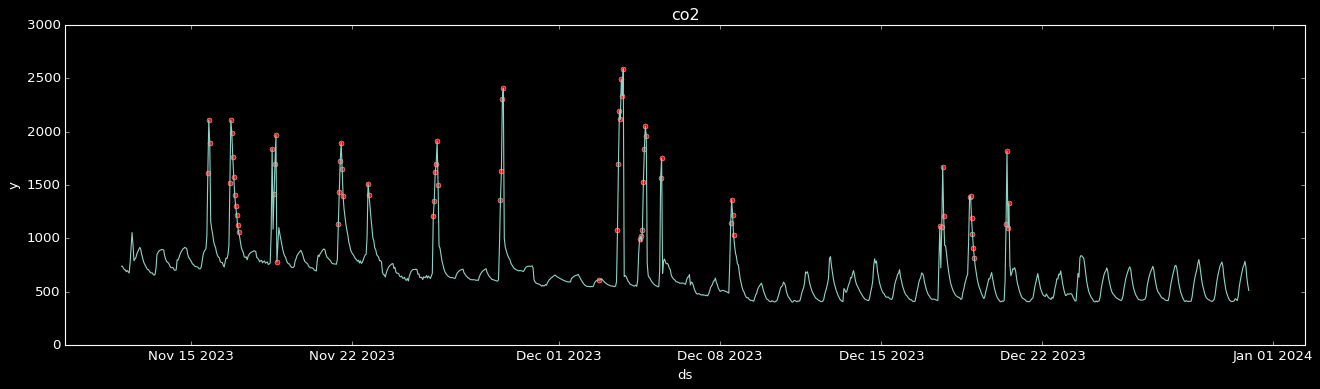

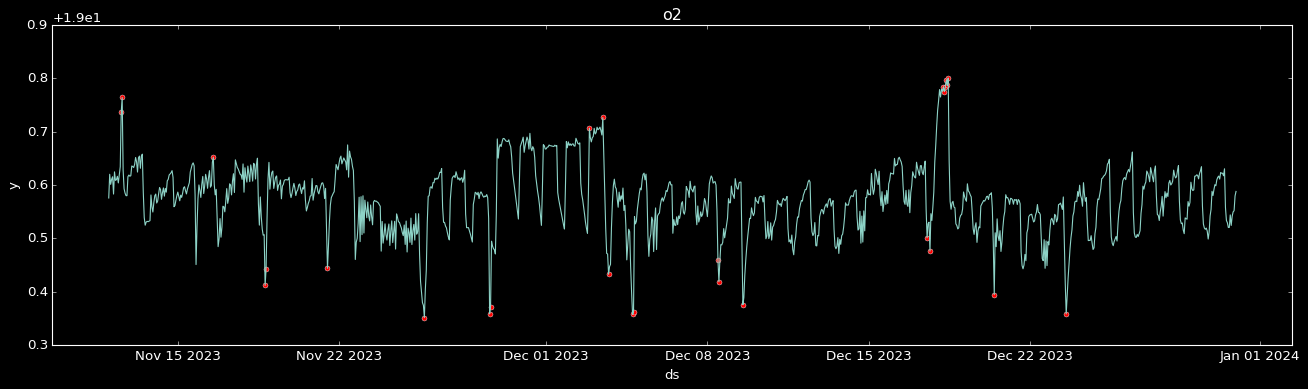

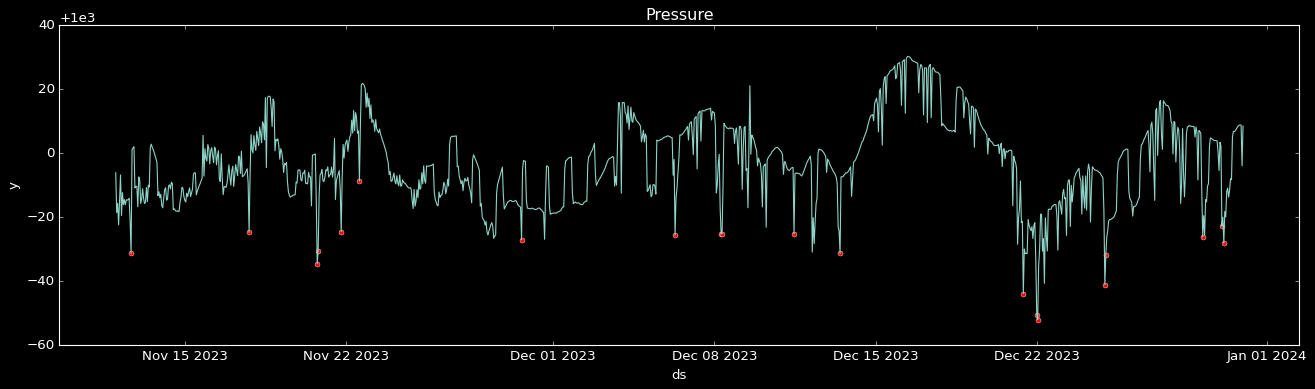

In [79]:
plot_anomalies(T_forecast)
plt.title('Temperature')
plot_anomalies(H_forecast)
plt.title('Humidity')
plot_anomalies(co2_forecast)
plt.title('co2')
plot_anomalies(o2_forecast)
plt.title('o2')
plot_anomalies(P_forecast)
plt.title('Pressure')

In [80]:
# We summarize all anomalies detected on every sensor
anomal_conds = ((o2_forecast.loc[:, 'anomaly'] == -1)
              | (co2_forecast.loc[:, 'anomaly'] == -1)
              | (T_forecast.loc[:, 'anomaly'] == -1)
              | (H_forecast.loc[:, 'anomaly'] == -1)
              | (P_forecast.loc[:, 'anomaly'] == -1))


anomaly_ph = pd.DataFrame(index = data.index)
anomaly_ph['anomaly'] = np.where(anomal_conds, -1, 1)


anomaly_ph['anomaly'].value_counts(normalize=True)

anomaly
 1    0.888605
-1    0.111395
Name: proportion, dtype: float64

In [81]:
# adding these results to our 'data' df
data['anomaly_value_ph'] = anomaly_ph['anomaly']

**Conclusions:** at the moment the effectiveness of the models can only be assessed visually, answering the question of whether the model detects anomalies that are 100% anomalous from our point of view. A conversation was held with an expert, working in a container, and it was agreed that we will try to olabel points that are 100% anomalous from the expert's point of view. So, we will validate the model to detect those anomalies that are obvious to us, expecting the model to detect them, in addition to the points about which we are not sure ourselves whether they are anomalies or not. 

In the next steps, thresholds for each sensor was determined together with the expert, taking into account that we care most about detecting strongly extreme values (either very high or very low), visible to the “naked eye.” 

## Manual data labeling

Based on statistics such as percentiles, median, mean, standard deviation, thresholds for each of the sensors located at the measurement point were established together with an expert, with which the data was olabelled for model validation.

In [82]:
data[sensors].describe()

nodeID       o2.019      co2.019        T.019        H.019        P.019
count   1176.000000  1176.000000  1176.000000  1176.000000  1176.000000
mean      19.573317   683.279616    15.914719    84.468749   997.073332
std        0.062336   283.759787     1.282655     9.374908    12.992369
min       19.351333   402.258333    10.414500    55.700000   947.955833
25%       19.533479   504.060417    15.112604    75.360208   987.910000
50%       19.576125   629.754167    15.777292    82.708750   995.982500
75%       19.610604   762.437500    16.579062    93.798750  1005.689375
max       19.800750  2589.941667    19.646917   100.000000  1030.209167

Text(0.5, 1.0, 'o2 timeline with thresholds')

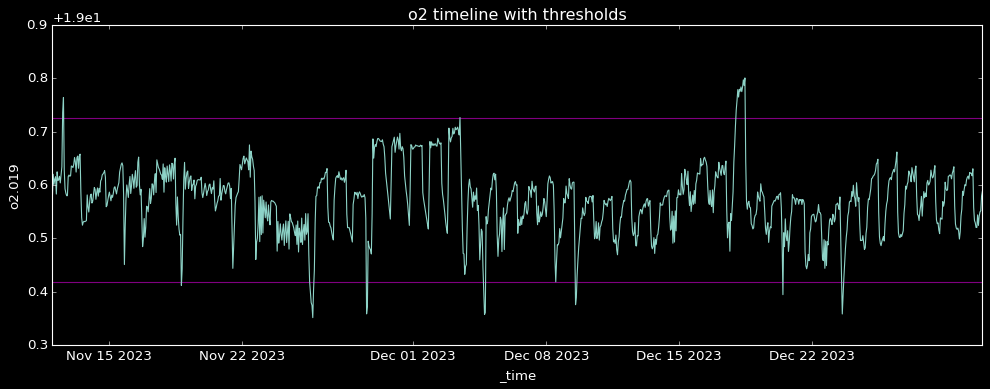

In [83]:
# finding the best thresholds using iqr method
iqr_o2 = iqr(data['o2.019'])
quartile_1_o2 = data.describe().loc['25%', 'o2.019']
quartile_3_o2 = data.describe().loc['75%', 'o2.019']
u_threshold_o2 = quartile_1_o2 + 2.5*iqr_o2
l_threshold_o2 = quartile_3_o2 - 2.5*iqr_o2

# here we've changed standard 1.5 to 2.5 for better fit to expert's opinion

# plotting the timeline with thresholds
plt.figure(figsize=(15, 5))
plt.axhline(u_threshold_o2, color = 'purple')
plt.axhline(l_threshold_o2, color = 'purple')
sns.lineplot(data, x = data.index, y = 'o2.019')
plt.title('o2 timeline with thresholds')

Text(0.5, 1.0, 'co2 timeline with thresholds')

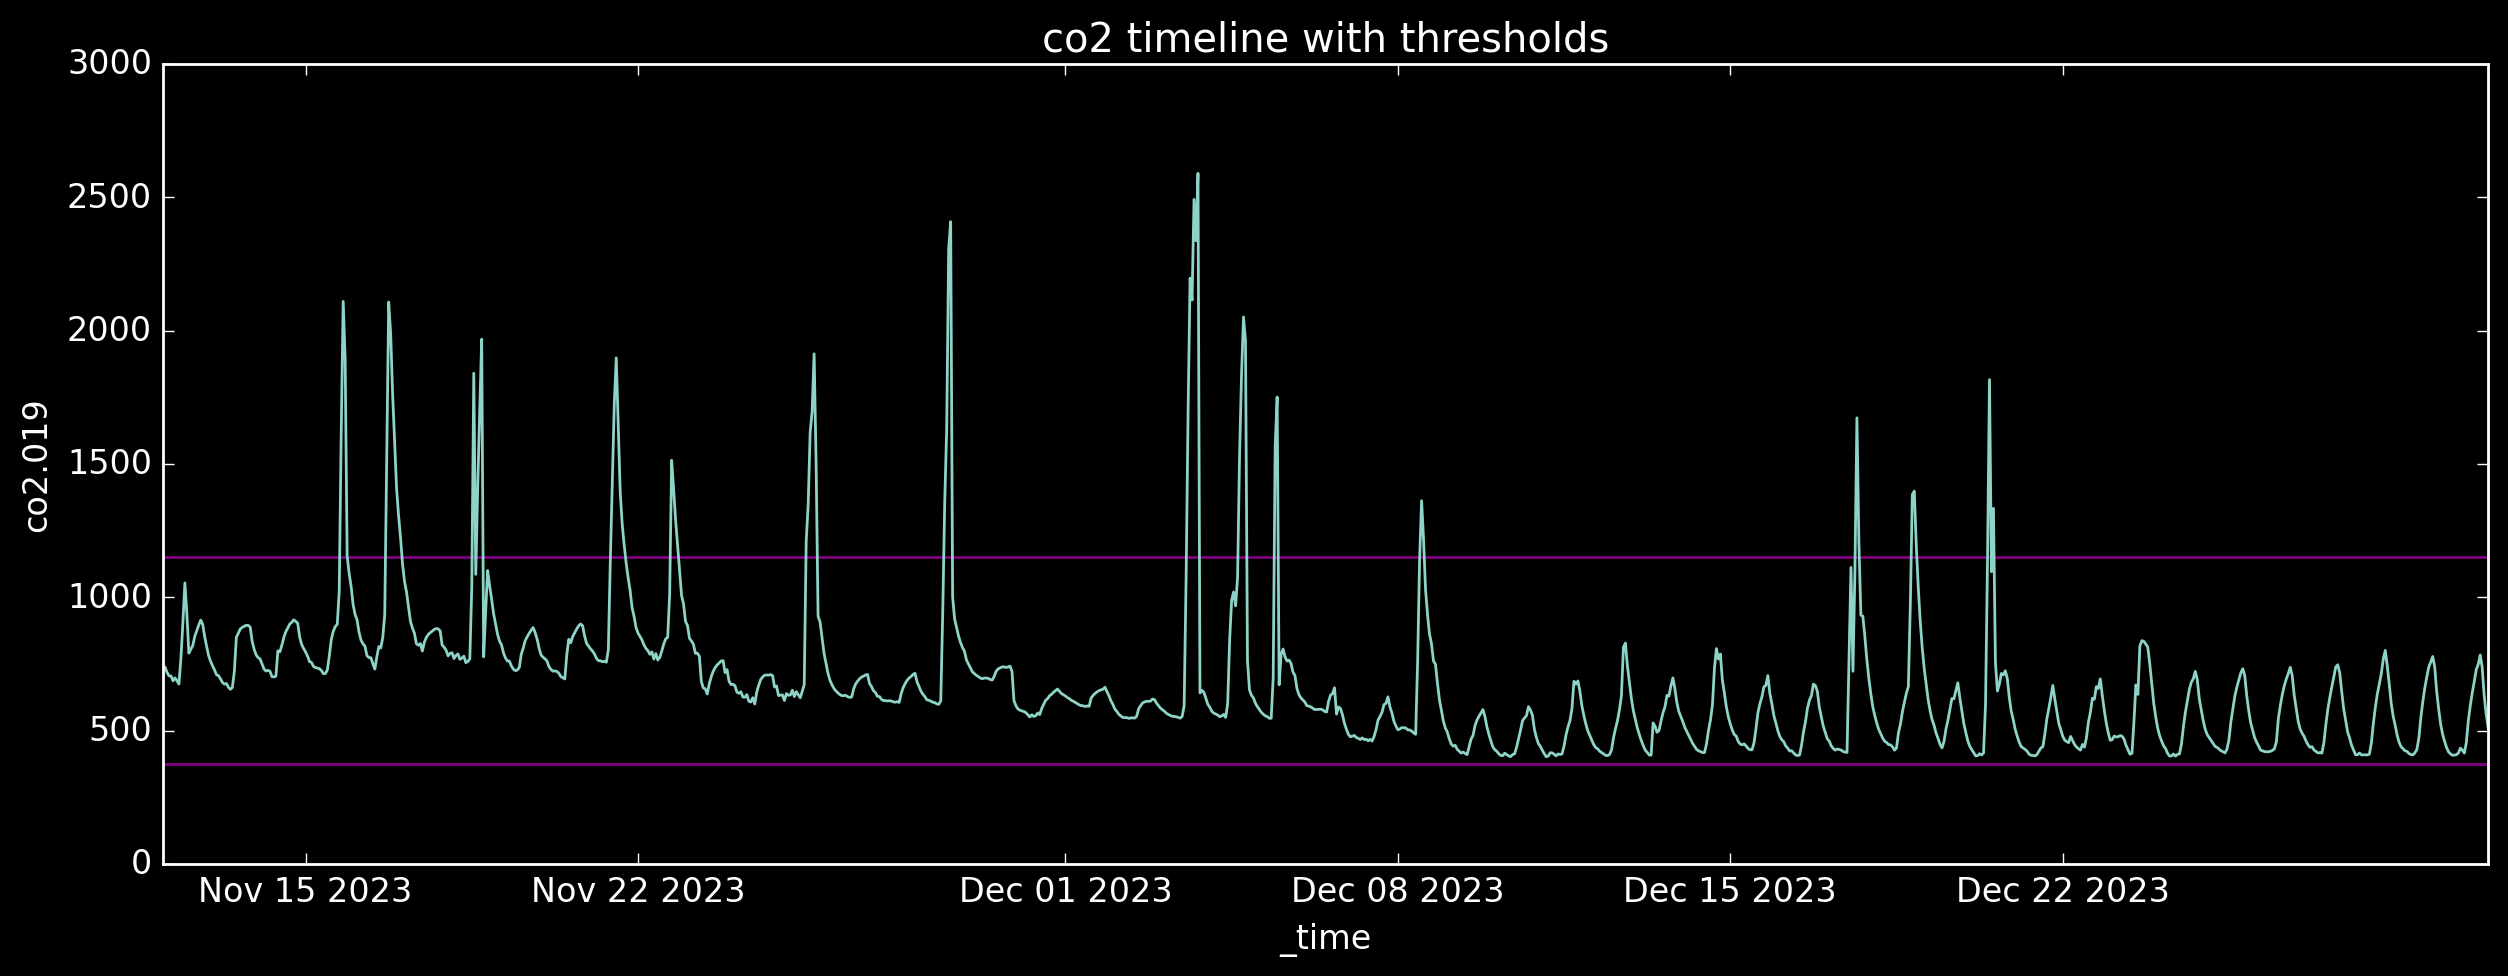

In [84]:
# finding the best thresholds using iqr method
iqr_co2 = iqr(data['co2.019'])
quartile_1_co2 = data.describe().loc['25%', 'co2.019']
quartile_3_co2 = data.describe().loc['75%', 'co2.019']
u_threshold_co2 = quartile_1_co2 + 2.5*iqr_co2 # here we've changed standard 1.5 to 2.5 for better fit to expert's opinion
l_threshold_co2 = quartile_3_co2 - 1.5*iqr_co2 

# plotting the timeline with thresholds
plt.figure(figsize=(15, 5), dpi = 200)
plt.axhline(u_threshold_co2, color = 'purple')
plt.axhline(l_threshold_co2, color = 'purple')
sns.lineplot(data, x = data.index, y = 'co2.019')
plt.title('co2 timeline with thresholds')

Text(0.5, 1.0, 'Temperature timeline with thresholds')

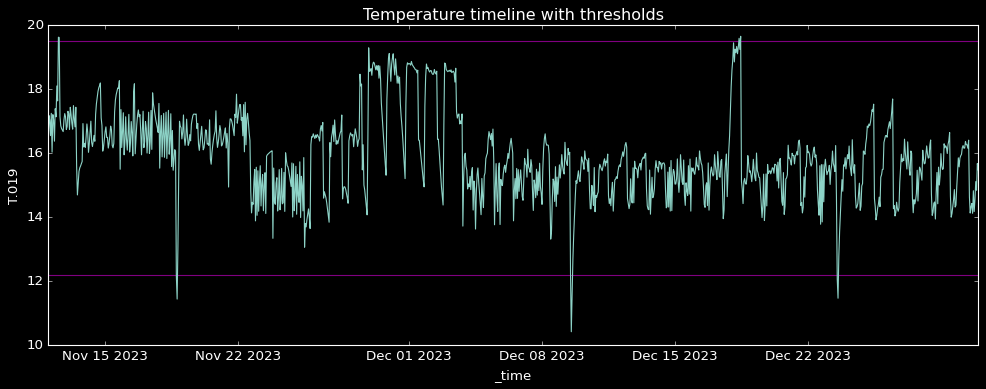

In [85]:
iqr_T = iqr(data['T.019'])
quartile_1_T = data.describe().loc['25%', 'T.019']
quartile_3_T = data.describe().loc['75%', 'T.019']
u_threshold_T = quartile_1_T + 3*iqr_T 
l_threshold_T = quartile_3_T - 3*iqr_T
# here we've changed standard 1.5 to 3 for better fit to expert's opinion

plt.figure(figsize=(15, 5))
plt.axhline(u_threshold_T, color = 'purple')
plt.axhline(l_threshold_T, color = 'purple')
sns.lineplot(data, x = data.index, y = 'T.019')
plt.title('Temperature timeline with thresholds')

Text(0.5, 1.0, 'Humidity timeline with thresholds')

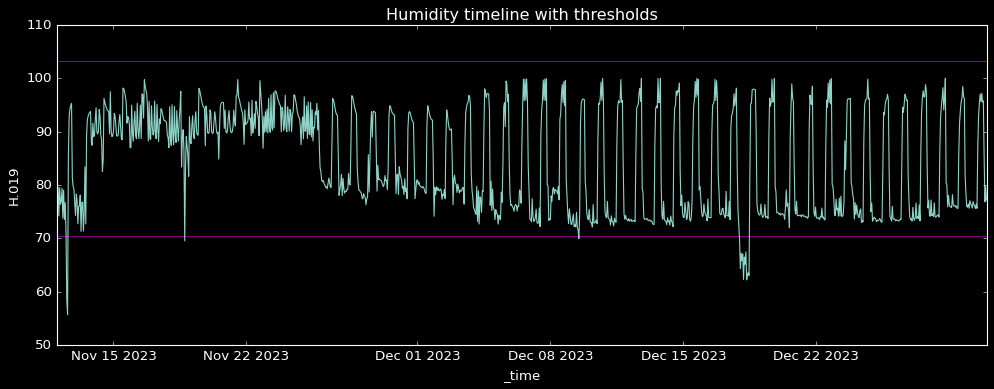

In [86]:
u_threshold_H_new = data.describe().loc['mean', 'H.019'] + 2*data.describe().loc['std', 'H.019']
l_threshold_H_new = data.describe().loc['mean', 'H.019'] - 1.5*data.describe().loc['std', 'H.019']

# here the iqr method didn't work out, I've used mean and std (not classic 3 sigma) for better fit to expert's opinion

# plotting the timeline with thresholds
plt.figure(figsize=(15, 5))
plt.axhline(u_threshold_H_new, color = 'purple')
plt.axhline(l_threshold_H_new, color = 'purple')
sns.lineplot(data, x = data.index, y = 'H.019')
plt.title('Humidity timeline with thresholds')

In [87]:
# defining the set of conditions based on thresholds
conditions = ((data.loc[:, 'H.019'] < l_threshold_H_new)
              | (data.loc[:, 'H.019'] > u_threshold_H_new) 
              | (data.loc[:, 'o2.019'] < l_threshold_o2) 
              | (data.loc[:, 'o2.019'] > u_threshold_o2)
              | (data.loc[:, 'co2.019'] < l_threshold_co2)
              | (data.loc[:, 'co2.019'] > u_threshold_co2)
              | (data.loc[:, 'T.019'] < l_threshold_T)
              | (data.loc[:, 'T.019'] > u_threshold_T)) 

# creating the column 'anomaly' where data is lower/upper then thresholds is anomaly (-1), normal (1) - I use -1/1 here, because models mark the anomalies/normal data this way
data['anomaly'] = np.where(conditions, -1, 1)

In [88]:
data['anomaly'].value_counts(normalize=True) # checking out for what percent of anomalies in dataset we definitely know that are anomalies

anomaly
 1    0.930272
-1    0.069728
Name: proportion, dtype: float64

**Conclusions:** As a result of manually olabeling the data together with an expert, about 7% of the anomalies in the dataset were found, these are anomalies where we are sure that they are anomalous values. In addition, we would like the model to detect points that, for us, are not clear in the context of anomaly/non-anomaly. Therefore, we will assume that we want the model to detect 10% of anomalies in the entire dataset.

Now that we have an understanding of which points we care most about detecting, we can proceed to find the best model and the best hyperparameters for it. We care most about detecting anomalies at points where we are 100% sure it is an anomaly (TP), hence the metric we are most interested in is recall (TP/TP+FN), in addition we will examine precision and F1(macro, since the classes are heavily unbalanced, and we care about treating the classes the same).

## Models evaluation and tuning

In [89]:
# classification report from model (we're particular interested in catching the -1 class right, so the most important metrics for us are recall and f1 for -1 class, and to value all model, recall and f1 macro average)
report_clf_if = classification_report(y_true=data['anomaly'], y_pred=data['anomaly_value_if'])
print(report_clf_if)

              precision    recall  f1-score   support

          -1       0.64      0.91      0.75        82
           1       0.99      0.96      0.98      1094

    accuracy                           0.96      1176
   macro avg       0.81      0.94      0.86      1176
weighted avg       0.97      0.96      0.96      1176



In [90]:
report_clf_lof = classification_report(y_true=data['anomaly'], y_pred=data['anomaly_value_lof'])
print(report_clf_lof)

              precision    recall  f1-score   support

          -1       0.30      0.43      0.35        82
           1       0.96      0.92      0.94      1094

    accuracy                           0.89      1176
   macro avg       0.63      0.68      0.64      1176
weighted avg       0.91      0.89      0.90      1176



In [91]:
report_clf_svm = classification_report(y_true=data['anomaly'], y_pred=data['anomaly_value_svm'])
print(report_clf_svm)

              precision    recall  f1-score   support

          -1       0.45      0.65      0.53        82
           1       0.97      0.94      0.96      1094

    accuracy                           0.92      1176
   macro avg       0.71      0.79      0.74      1176
weighted avg       0.94      0.92      0.93      1176



In [92]:
report_clf_prophet = classification_report(y_true=data['anomaly'], y_pred=data['anomaly_value_ph'])
print(report_clf_prophet)

              precision    recall  f1-score   support

          -1       0.57      0.91      0.70        82
           1       0.99      0.95      0.97      1094

    accuracy                           0.95      1176
   macro avg       0.78      0.93      0.84      1176
weighted avg       0.96      0.95      0.95      1176



**Conclusions:** the best results were obtained by the Isolation Forest model, hence we will continue to try further tuning it. Prophet also obtained quite good results.

*No cross-validation was performed because the Local Outlier Factor model does not have a .predict() method - we could not solve this problem.*

In [93]:
# defining the set of hyperparams to tune in next step
max_features = [1, 2, 3, 4, 5] # how many features from dataset iForest will choose for split
bootstrap=[True, False] # draw with return or not
param_grid = dict(max_features=max_features, bootstrap=bootstrap)
grid = GridSearchCV(estimator=clf_if, param_grid=param_grid, cv = 5, scoring='f1_macro')
search_grid = grid.fit(data[sensors], data['anomaly'])

In [94]:
search_grid.best_params_

{'bootstrap': False, 'max_features': 3}

In [95]:
data['anomaly_value_if_tuned'] = search_grid.best_estimator_.predict(data[sensors])
report_clf_if_tuned = classification_report(y_true=data['anomaly'], y_pred=data['anomaly_value_if_tuned'])
print(report_clf_if_tuned)

              precision    recall  f1-score   support

          -1       0.64      0.93      0.76        82
           1       0.99      0.96      0.98      1094

    accuracy                           0.96      1176
   macro avg       0.82      0.94      0.87      1176
weighted avg       0.97      0.96      0.96      1176



Visualizing the model's results.

In [96]:
# writing classification reports as a dictionaries
report_clf_if_new = classification_report(y_true=data['anomaly'], y_pred=data['anomaly_value_if'], output_dict=True)
report_clf_lof_new = classification_report(y_true=data['anomaly'], y_pred=data['anomaly_value_lof'], output_dict=True)
report_clf_svm_new = classification_report(y_true=data['anomaly'], y_pred=data['anomaly_value_svm'], output_dict=True)
report_clf_if_tuned_new = classification_report(y_true=data['anomaly'], y_pred=data['anomaly_value_if_tuned'], output_dict=True)
report_clf_ph_new = classification_report(y_true=data['anomaly'], y_pred=data['anomaly_value_ph'], output_dict=True)

In [97]:
# creating the list of reports (dictionaries)
reports = [report_clf_if_new, 
           report_clf_lof_new, 
           report_clf_svm_new, 
           report_clf_if_tuned_new, 
           report_clf_ph_new]

In [98]:
# iteration through the model's reports and creating lists for three metrics
model_names = ['iForest', 'LOF', 'OneClassSVM', 'iForestTuned', 'Prophet']
recall = []
precision = []
f1 = []

for report in reports:
    recall.append(report['-1']['recall'])

for report in reports:
    precision.append(report['-1']['precision'])

for report in reports:
    f1.append(report['-1']['f1-score'])

In [99]:
# creating the df consisting of models and metrics
anomaly_scores = pd.DataFrame({'model_name': model_names, 'recall': recall, 'precision': precision, 'f1':f1})
anomaly_scores_melted = anomaly_scores.melt(id_vars=['model_name'], value_vars=['recall', 'precision', 'f1'])
anomaly_scores_melted

model_name   variable     value
0        iForest     recall  0.914634
1            LOF     recall  0.426829
2    OneClassSVM     recall  0.646341
3   iForestTuned     recall  0.926829
4        Prophet     recall  0.914634
5        iForest  precision  0.635593
6            LOF  precision  0.296610
7    OneClassSVM  precision  0.452991
8   iForestTuned  precision  0.644068
9        Prophet  precision  0.572519
10       iForest         f1  0.750000
11           LOF         f1  0.350000
12   OneClassSVM         f1  0.532663
13  iForestTuned         f1  0.760000
14       Prophet         f1  0.704225

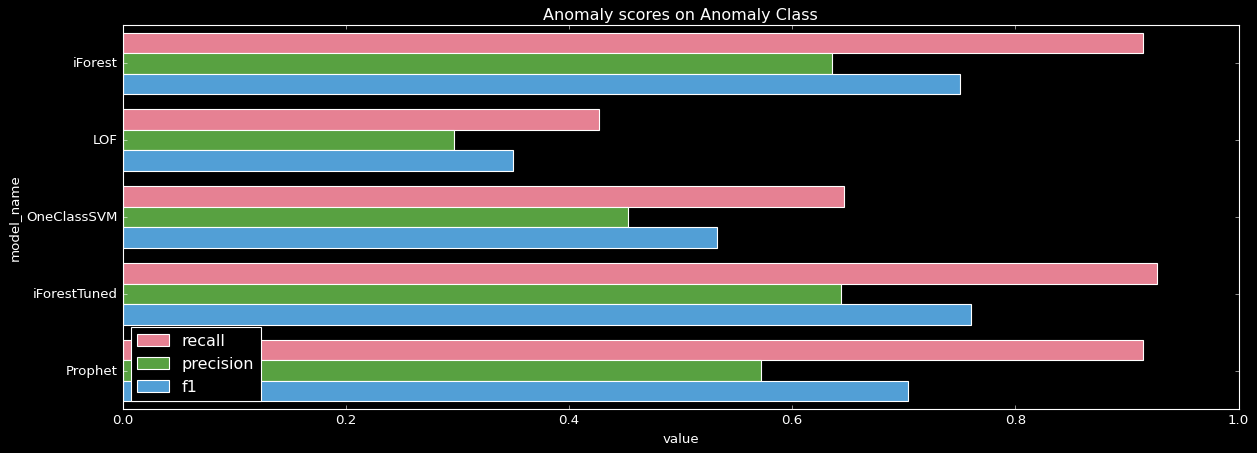

In [100]:
# plotting all three metrics for all four models to compare results
plt.figure(figsize=(18,6))
sns.barplot(anomaly_scores_melted, y = 'model_name', x = 'value', hue = 'variable', palette = 'husl')
plt.title('Anomaly scores on Anomaly Class')
plt.legend(loc = 'lower left')

From the above chart and classification reports, it appears that the iForest, iForestTuned and Prophet models have very similar results when it comes to recall, but in the context of other metrics Prophet slightly loses. Cross-validation of the f1-macro and recall-macro metrics for the iForest and iForestTuned models was performed.

In [101]:
cv = StratifiedKFold(n_splits=10, random_state=123, shuffle=True)

In [102]:
# cv for recall-macro for iForest
clf_if_cv_recall = cross_val_score(
    clf_if, 
    data[sensors],
    data['anomaly'],
    scoring='recall_macro',
    cv = cv
)

# cv for recall-macro for iForestTuned
clf_if_best_cv_recall = cross_val_score(
    search_grid.best_estimator_, 
    data[sensors],
    data['anomaly'],
    scoring='recall_macro', 
    cv = cv
)

d = {'clf_if': clf_if_cv_recall, 'clf_if_tuned': clf_if_best_cv_recall,}
scores_recall = pd.DataFrame(d)

In [103]:
# non-parametric t-test to compare two results, p-val > 0.05 and alternative is 'less' what means that the first result is lower than second, but CLES is 57.5%, what means that only in 57.5% cases results from first cv are lower than from second
pingouin.mwu(x = clf_if_cv_recall, y = clf_if_best_cv_recall, alternative='less')

U-val alternative     p-val   RBC   CLES
MWU   42.5        less  0.297448  0.15  0.575

In [104]:
# cv for f1-macro for iForest
clf_if_cv_f1 = cross_val_score(
    clf_if, 
    data[sensors],
    data['anomaly'],
    scoring='f1_macro',
    cv = cv
)

# cv for f1-macro for iForestTuned
clf_if_best_cv_f1 = cross_val_score(
    search_grid.best_estimator_, 
    data[sensors],
    data['anomaly'],
    scoring='f1_macro', 
    cv = cv
)

f = {'clf_if': clf_if_cv_f1, 'clf_if_tuned': clf_if_best_cv_f1}
scores_f1 = pd.DataFrame(f)

In [105]:
pingouin.mwu(x = clf_if_cv_f1, y = clf_if_best_cv_f1, alternative='less') # the same interpretation as previous

U-val alternative     p-val   RBC  CLES
MWU   43.0        less  0.310799  0.14  0.57

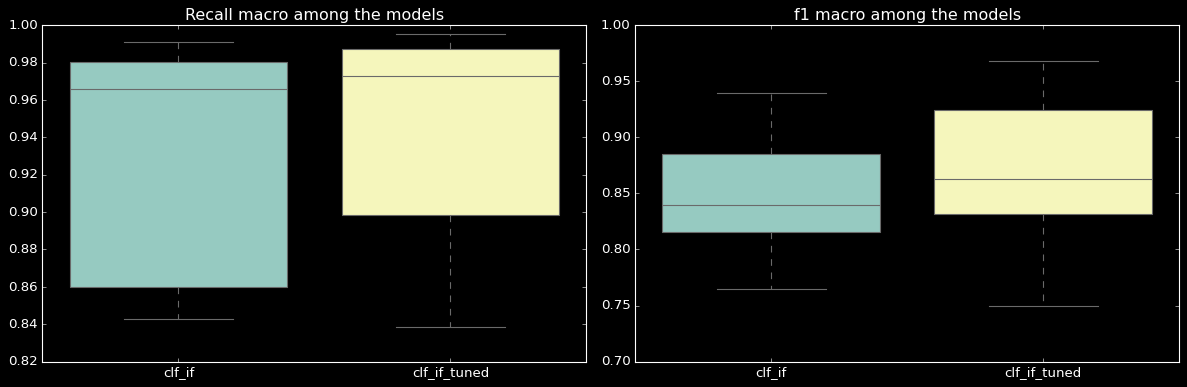

In [106]:
# plotting the results from cv for both metrics for both models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
sns.boxplot(scores_recall, ax = ax1)
ax1.set_title('Recall macro among the models')

sns.boxplot(scores_f1, ax = ax2)
ax2.set_title('f1 macro among the models')

plt.tight_layout()

The iForestTuned model performs micro-micro better than the iForest baseline model. For additional evaluation of the models, I visualized the models using PCA to see what points besides the ones we defined the models detect as anomalies.

## PCA for models performance visualization

Using the PCA model, the dimensionality of the dataset was reduced from 5 to 2, so that points and anomalies could be visualized on the scatter plot.

In [107]:
# PCA model for two PC
pca = PCA(n_components=2)
scaler = StandardScaler()
pca_pipeline = make_pipeline(scaler, pca)

In [108]:
data_pca = pca_pipeline.fit_transform(data[sensors])

In [109]:
# the df of 2 PC
df_pca = pd.DataFrame(data_pca,
                       columns=['PC1', 'PC2'], index = data.index)

In [110]:
# the df of 2 PC with labels and models outputs
df_pca_new = pd.concat([df_pca, data[['anomaly', 'anomaly_value_if', 'anomaly_value_lof', 'anomaly_value_svm', 'anomaly_value_if_tuned', 'anomaly_value_ph']]], axis=1)
df_pca_new

PC1       PC2  anomaly  anomaly_value_if  \
_time                                                                      
2023-11-12 00:00:00+00:00  0.405672 -0.023520        1                 1   
2023-11-12 01:00:00+00:00  1.606660  0.763168        1                 1   
2023-11-12 02:00:00+00:00  1.205875  0.678591        1                 1   
2023-11-12 03:00:00+00:00  1.506520  0.443372        1                 1   
2023-11-12 04:00:00+00:00  1.411843  0.687476        1                 1   
...                             ...       ...      ...               ...   
2023-12-30 19:00:00+00:00 -1.765684 -0.137260        1                 1   
2023-12-30 20:00:00+00:00 -0.910177 -0.511989        1                 1   
2023-12-30 21:00:00+00:00 -0.495023 -1.225889        1                 1   
2023-12-30 22:00:00+00:00  0.334010 -0.548622        1                 1   
2023-12-30 23:00:00+00:00  0.230140 -1.231175        1                 1   

                           anomaly_value_lof  anomaly_value_svm  \
_time                                                             
2023-11-12 00:00:00+00:00                  1                  1   
2023-11-12 01:00:00+00:00                  1                  1   
2023-11-12 02:00:00+00:00                  1                  1   
2023-11-12 03:00:00+00:00                  1                  1   
2023-11-12 04:00:00+00:00                  1                  1   
...                                      ...                ...   
2023-12-30 19:00:00+00:00                  1                  1   
2023-12-30 20:00:00+00:00                  1                  1   
2023-12-30 21:00:00+00:00                  1                  1   
2023-12-30 22:00:00+00:00                  1                  1   
2023-12-30 23:00:00+00:00                  1                  1   

                           anomaly_value_if_tuned  anomaly_value_ph  
_time                                                                
2023-11-12 00:00:00+00:00                       1                 1  
2023-11-12 01:00:00+00:00                       1                 1  
2023-11-12 02:00:00+00:00                       1                 1  
2023-11-12 03:00:00+00:00                       1                 1  
2023-11-12 04:00:00+00:00                       1                 1  
...                                           ...               ...  
2023-12-30 19:00:00+00:00                       1                 1  
2023-12-30 20:00:00+00:00                       1                 1  
2023-12-30 21:00:00+00:00                       1                 1  
2023-12-30 22:00:00+00:00                       1                 1  
2023-12-30 23:00:00+00:00                       1                 1  

[1176 rows x 8 columns]

C:\Users\vasya\AppData\Local\Temp\ipykernel_21556\649770456.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(df_pca_new, x = 'PC1', y = 'PC2', ax = ax, hue = hue, palette='inferno')


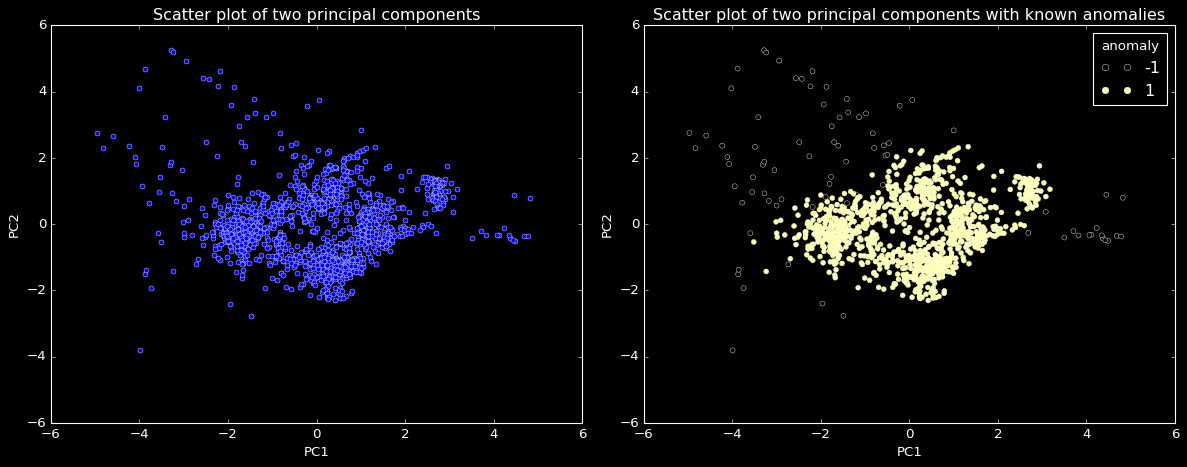

In [111]:
# definition of the scatter plotting func

def scatter_plotting(ax, title, hue=None):
    sns.scatterplot(df_pca_new, x = 'PC1', y = 'PC2', ax = ax, hue = hue, palette='inferno')
    ax.set_title(title)

# plotting the 2 PC without and with 7% known anomalies 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,6))

scatter_plotting(ax1, 'Scatter plot of two principal components')
scatter_plotting(ax2, 'Scatter plot of two principal components with known anomalies', hue = 'anomaly')

plt.tight_layout()

In [112]:
# definition of the anomalies plotting func
def plot_anomalies(ax, data, title, anomaly_value_col):
    sns.scatterplot(data[data['anomaly'] == -1], x='PC1', y='PC2', color='orange', ax=ax,  label='True anomalies')
    sns.scatterplot(data[data[anomaly_value_col] == -1], 
                    x='PC1', 
                    y='PC2', 
                    s=100, 
                    edgecolor='green', 
                    facecolor='none', 
                    alpha=1, 
                    ax=ax, 
                    label='Detected anomalies')
    ax.set_title(title)
    ax.legend()

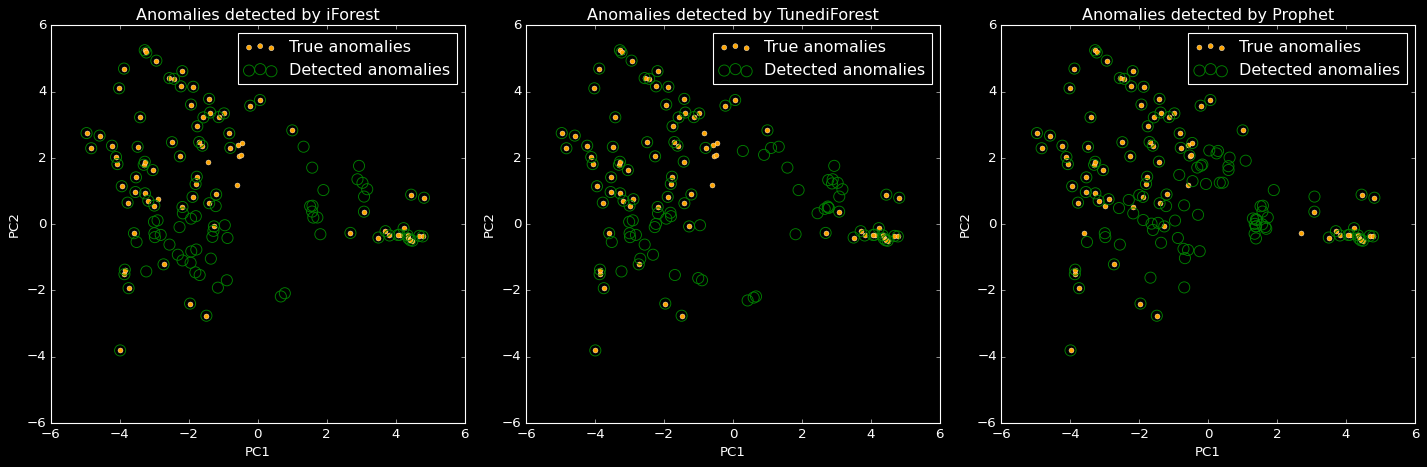

In [113]:
# plotting anomalies detecting by Prophet

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

plot_anomalies(ax1, df_pca_new, 'Anomalies detected by iForest', 'anomaly_value_if')
plot_anomalies(ax2, df_pca_new, 'Anomalies detected by TunediForest', 'anomaly_value_if_tuned')
plot_anomalies(ax3, df_pca_new, 'Anomalies detected by Prophet', 'anomaly_value_ph')

plt.tight_layout()

**Conclusions**: Using PCA-based graphs, it was examined what points in addition to the 7% that we definitively know are anomalies the models detect. Since the metrics analyzed in the previous step take into account only 7% of anomalies, and the values of the metrics came out very close to each other, it is worth evaluating what points the models propose as an additional 3% of anomalies. 

Analyzing the graphs above, you can see that Prophet detects points that are not at first glance anomalies, at the same time it is impossible to say clearly which of the iForest models (baseline or tuned) detects more “ reasonable points ”, on part of the graph one model did better, on another part the other.

Since the evaluation metrics based on 7% anomalies do not show a significant difference in performance for the two models (recall 94% for both models, f1 86% for iForest 87% for iForestTuned), on the PCA chart they also perform very similarly, in addition, given the propensity of iForest-type models to overfit, it is recommended to choose the iForest base model as the target model.

Thank you very much for your attention!